# Stage 2: Advanced Embedding Models Training and Analysis
This notebook explores advanced embedding models to analyze and compare the content of the Cleantech Media and Google Patent datasets. The goal is to develop meaningful vector representations of the text data using word embeddings, sentence embeddings, and transfer learning techniques.

- Deadline 2 (Stage 2): 6 April 2025 23:59

## Data Preparation for Embeddings
At this stage, we need to ensure that our dataset is properly cleaned and preprocessed to generate high-quality embeddings.


In [ ]:
#Packages
import pandas as pd
import re
import numpy as np
from bs4 import BeautifulSoup
import unidecode
import spacy
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
PUNCTUATIONS = string.punctuation
stemmer = PorterStemmer()
from collections import Counter
from gensim.models import Word2Vec

import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
# Default Style Settings
matplotlib.rcParams['figure.dpi'] = 300
pd.options.display.max_colwidth = 200
#%matplotlib inline

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [18]:
!pip install gensim
!pip install spacy
!pip install unidecode

In [ ]:
#load the pre-cleaned dataset
media_preprocessed_path = "../cleaned_data/media_dataset_pre-cleaned.csv"
patent_preprocessed_path = "../cleaned_data/google_patent_pre-cleaned.csv"

df_media_read = pd.read_csv(media_preprocessed_path, header = 0)
df_patent_read = pd.read_csv(patent_preprocessed_path, header = 0)
df_media_processed = df_media_read.copy()
df_patent_processed = df_patent_read.copy()

First, all function for the preprocessing steps are loaded:

In [20]:
def remove_emails(text):
    return re.sub(r'\S+@\S+', '', text) if isinstance(text, str) else text

def remove_dates(text):
    text = re.sub(r'\d{1,2}(st|nd|rd|th)?[-./]\d{1,2}[-./]\d{2,4}', '', text)
    pattern = re.compile(r'(\d{1,2})?(st|nd|rd|th)?[-./,]?\s?(of)?\s?([J|j]an(uary)?|[F|f]eb(ruary)?|[Mm]ar(ch)?|[Aa]pr(il)?|[Mm]ay|[Jj]un(e)?|[Jj]ul(y)?|[Aa]ug(ust)?|[Ss]ep(tember)?|[Oo]ct(ober)?|[Nn]ov(ember)?|[Dd]ec(ember)?)\s?(\d{1,2})?(st|nd|rd|th)?\s?[-./,]?\s?(\d{2,4})?')
    text = pattern.sub(r'', text)
    return text if isinstance(text, str) else text

def remove_html(text):
    clean_text = BeautifulSoup(text).get_text()
    return clean_text

def remove_tags_mentions(text):
    pattern = re.compile(r'(@\S+|#\S+)')
    return pattern.sub('', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))


def remove_whitespaces(text):
    return " ".join(text.split())


def accented_to_ascii(text):
    return unidecode.unidecode(text)

# Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenize(text):
  return [t.text.lower() for t in nlp(text)]

Now we apply the function to both datasets. Stopwords are retained in both the Media and Patent datasets to preserve the **natural text structure** and **important contextual relationships**. This ensures that **technical expressions in patents** and **domain-specific phrasing in media** remain intact.  

While keeping stopwords increases **dataset size** and **computational cost**, potentially introducing some noise in word embeddings, removing them could **disrupt the meaning of technical terms** in patents and **reduce readability** in media content, leading to a loss of **critical context**.  


In [21]:
# lower casing
df_media_processed['content'] = df_media_processed['content'].apply(lambda x: x.lower())

# Call all removals
df_media_processed['content'] = df_media_processed['content'].map(remove_emails)
df_media_processed['content'] = df_media_processed['content'].map(remove_dates)
df_media_processed['content'] = df_media_processed['content'].map(remove_html)
df_media_processed['content'] = df_media_processed['content'].map(remove_tags_mentions)
df_media_processed['content'] = df_media_processed['content'].map(remove_punctuation)
df_media_processed['content'] = df_media_processed['content'].map(remove_whitespaces)
df_media_processed['content'] = df_media_processed['content'].map(accented_to_ascii)
df_media_processed['tokens'] = df_media_processed['content'].apply(tokenize)


df_media_processed.head()

id  \
0  93320   
1  93321   
2  98159   
3  98158   
4  31128   

                                                                                           title  \
0                                                      XPeng Delivered ~100,000 Vehicles In 2021   
1                                                  Green Hydrogen: Drop In Bucket Or Big Splash?   
2            World’ s largest floating PV plant goes online in China – pv magazine International   
3  Iran wants to deploy 10 GW of renewables over the next four years – pv magazine International   
4                        Eastern Interconnection Power Grid Said ‘ Being Challenged in New Ways’   

         date  \
0  2022-01-02   
1  2022-01-02   
2  2022-01-03   
3  2022-01-03   
4  2022-01-03   

                                                                                                                                                                                                   content  \
0  chinese automotive startup xpeng has shown one of the most dramatic auto production rampups in history and the good news is it only produces 100 st electric vehicles evs at a mere 7 years of age a...   
1  sinopec has laid plans to build the largest green hydrogen production facility in the world but interest in fossilsourced hydrogen continues apace skepticism abounds over the green hydrogen field ...   
2  huaneng power international has switched on a 320 mw floating pv array in china' s shandong province it deployed the plant in two phases on a reservoir near its 265 gw dezhou thermal power station...   
3  according to the iranian authorities there are currently more than 80gw of renewable energy projects that were submitted by private investors for review iran had around 414mw of installed solar po...   
4  daily gpi infrastructure ngi all news access electric transmission planners with the eastern interconnection a major power grid serving twothirds of the united states and canada recently gave a fa...   

            domain  \
0    cleantechnica   
1    cleantechnica   
2      pv-magazine   
3      pv-magazine   
4  naturalgasintel   

                                                                                                                  url  \
0                                       https://cleantechnica.com/2022/01/02/xpeng-delivered-100000-vehicles-in-2021/   
1      https://cleantechnica.com/2022/01/02/its-a-green-hydrogen-drop-in-the-bucket-but-it-could-still-make-a-splash/   
2                       https://www.pv-magazine.com/2022/01/03/worlds-largest-floating-pv-plant-goes-online-in-china/   
3  https://www.pv-magazine.com/2022/01/03/iran-wants-to-deploy-10-gw-of-renewables-over-the-next-four-years/#comments   
4               https://www.naturalgasintel.com/eastern-interconnection-power-grid-said-being-challenged-in-new-ways/   

                                                                                                                                                                                                    tokens  
0  [chinese, automotive, startup, xpeng, has, shown, one, of, the, most, dramatic, auto, production, rampups, in, history, and, the, good, news, is, it, only, produces, 100, st, electric, vehicles, e...  
1  [sinopec, has, laid, plans, to, build, the, largest, green, hydrogen, production, facility, in, the, world, but, interest, in, fossilsourced, hydrogen, continues, apace, skepticism, abounds, over,...  
2  [huaneng, power, international, has, switched, on, a, 320, mw, floating, pv, array, in, china, ', s, shandong, province, it, deployed, the, plant, in, two, phases, on, a, reservoir, near, its, 265...  
3  [according, to, the, iranian, authorities, there, are, currently, more, than, 80gw, of, renewable, energy, projects, that, were, submitted, by, private, investors, for, review, iran, had, around, ...  
4  [daily, gpi, infrastructure, ngi, all, news, access, electric, transmission, planners, with, the, easter

In [25]:
# lower casing
df_patent_processed['abstract'] = df_patent_processed['abstract'].apply(lambda x: x.lower())

# Call all removals
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_emails)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_dates)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_html)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_tags_mentions)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_punctuation)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(remove_whitespaces)
df_patent_processed['abstract'] = df_patent_processed['abstract'].map(accented_to_ascii)
df_patent_processed['tokens'] = df_patent_processed['abstract'].apply(tokenize)

df_patent_processed.head()

publication_number application_number country_code  \
0     CN-117151396-A  CN-202311109834-A           CN   
1     CN-117147382-A  CN-202310985511-A           CN   
2     CN-113344288-B  CN-202110717505-A           CN   
3     CN-117153944-A  CN-202311209193-A           CN   
4     CN-116911695-B  CN-202311167289-A           CN   

                                                                                                             title  \
0  Distributed economic scheduling method for wind, solar, biogas and hydrogen multi-energy multi-microgrid system   
1          Device for monitoring hydrogen atom crossing grain boundary diffusion by using SKPFM and testing method   
2   Cascade hydropower station group water level prediction method and device and computer readable storage medium   
3                                    Heterojunction solar cell, preparation method thereof and photovoltaic module   
4                                                          Flexible resource adequacy evaluation method and device   

                                                                                                                                                                                                  abstract  \
0  the invention discloses a distributed economic dispatching method of a wind solar and methane hydrogen multienergy multimicrogrid system firstly the wind solar and hydrogen multienergy multimicrog...   
1  the invention provides a device and a method for monitoring hydrogen atom crossing grain boundary diffusion by using skpfm and relates to the technical field of hydrogen energy utilization the dev...   
2  the invention discloses a cascade hydropower station group water level prediction method a cascade hydropower station group water level prediction device and a computer readable storage medium and...   
3  the application provides a heteroction solar cell a preparation method thereof and a photovoltaic module and relates to the technical field of photovoltaics the preparation method of the heterocti...   
4  the invention relates to a flexible resource adequacy evaluation method and device of an electric power system belongs to the technical field of electric power and solves the problems that a large...   

   publication_date                                         inventor  \
0          20231201                      ['HU PENGFEI', 'LI ZIMENG']   
1          20231201  ['MA ZHAOXIANG', 'WANG CHENGXU', 'LIU ZHONGLI']   
2          20231201                                               []   
3          20231201                    ['TONG HONGBO', 'JIN YUPENG']   
4          20231201                                               []   

      cpc_code  is_english  \
0    G06Q50/06        True   
1    G01N13/00        True   
2    G06Q10/04        True   
3   H01L31/074        True   
4  H02J2203/20        True   

                                                                                                                                                                                                    tokens  
0  [the, invention, discloses, a, distributed, economic, dispatching, method, of, a, wind, solar, and, methane, hydrogen, multienergy, multimicrogrid, system, firstly, the, wind, solar, and, hydrogen...  
1  [the, invention, provides, a, device, and, a, method, for, monitoring, hydrogen, atom, crossing, grain, boundary, diffusion, by, using, skpfm, and, relates, to, the, technical, field, of, hydrogen...  
2  [the, invention, discloses, a, cascade, hydropower, station, group, water, level, prediction, method, a, cascade, hydropower, station, group, water, level, prediction, device, and, a, computer, re...  
3  [the, application, provides, a, heteroction, solar, cell, a, preparation, method, thereof, and, a, photovoltaic, module, and, relates, to, the, technical, field, of, photovoltaics, the, preparatio...  
4  [the, invention, relates, to, a, flexible, resource, adequacy, evaluation, me

In [26]:
df_media = df_media_processed.copy()
df_patent= df_patent_processed.copy()

For the RoBERTa Fine-Tuning (Transformer-Based Model) & Doc2Vec we have other data preprocessing requirements. In RoBERTa fo example the goal is to undestand contextual meaning of words using deep contexutal embedding. As RoBERTa uses punctuation to understand sentence meaning (e.g., questions, negation, and lists) we need an other dataset which preservs those. We will use the same dataset alsso for Doc2Vec.

**Doc2Vec:**
- Stopwords: Stopwords are crucial for sentence meaning (e.g., "not good" ≠ "good").
- Punctuation: Keep punctuation if it impacts meaning (e.g., "Let's eat, grandma" ≠ "Let's eat grandma").

**RoBERTa:**
- Stopword Removal: RoBERTa relies on full sentence structure, including stopwords. Removing them hurts performance.
- Punctuation: RoBERTa uses punctuation to understand sentence meaning (e.g., questions, negation, and lists).


In [31]:
df_media_tl = df_media_read.copy()
df_patent_tl = df_patent_read.copy()

In [32]:
# lower casing
df_media_tl['content'] = df_media_tl['content'].apply(lambda x: x.lower())

# Call all removals
df_media_tl['content'] = df_media_tl['content'].map(remove_emails)
df_media_tl['content'] = df_media_tl['content'].map(remove_dates)
df_media_tl['content'] = df_media_tl['content'].map(remove_html)
df_media_tl['content'] = df_media_tl['content'].map(remove_tags_mentions)
df_media_tl['content'] = df_media_tl['content'].map(remove_whitespaces)
df_media_tl['content'] = df_media_tl['content'].map(accented_to_ascii)
df_media_tl['tokens'] = df_media_tl['content'].apply(tokenize)


df_media_tl.head()

id  \
0  93320   
1  93321   
2  98159   
3  98158   
4  31128   

                                                                                           title  \
0                                                      XPeng Delivered ~100,000 Vehicles In 2021   
1                                                  Green Hydrogen: Drop In Bucket Or Big Splash?   
2            World’ s largest floating PV plant goes online in China – pv magazine International   
3  Iran wants to deploy 10 GW of renewables over the next four years – pv magazine International   
4                        Eastern Interconnection Power Grid Said ‘ Being Challenged in New Ways’   

         date  \
0  2022-01-02   
1  2022-01-02   
2  2022-01-03   
3  2022-01-03   
4  2022-01-03   

                                                                                                                                                                                                   content  \
0  ['chinese automotive startup xpeng has shown one of the most dramatic auto production ramp-ups in history, and the good news is it only produces 100% st electric vehicles ( evs). at a mere 7 years...   
1  ['sinopec has laid plans to build the largest green hydrogen production facility in the world, but interest in fossil-sourced hydrogen continues apace.', 'skepticism abounds over the green hydroge...   
2  ['huaneng power international has switched on a 320 mw floating pv array in china' s shandong province. it deployed the plant in two phases on a reservoir near its 2.65 gw dezhou thermal power sta...   
3  ['according to the iranian authorities, there are currently more than 80gw of renewable energy projects that were submitted by private investors for review.', 'iran had around 414mw of installed s...   
4  ['daily gpi', 'infrastructure | ngi all news access', 'electric transmission planners with the eastern interconnection, a major power grid serving two-thirds of the united states and canada, recen...   

            domain  \
0    cleantechnica   
1    cleantechnica   
2      pv-magazine   
3      pv-magazine   
4  naturalgasintel   

                                                                                                                  url  \
0                                       https://cleantechnica.com/2022/01/02/xpeng-delivered-100000-vehicles-in-2021/   
1      https://cleantechnica.com/2022/01/02/its-a-green-hydrogen-drop-in-the-bucket-but-it-could-still-make-a-splash/   
2                       https://www.pv-magazine.com/2022/01/03/worlds-largest-floating-pv-plant-goes-online-in-china/   
3  https://www.pv-magazine.com/2022/01/03/iran-wants-to-deploy-10-gw-of-renewables-over-the-next-four-years/#comments   
4               https://www.naturalgasintel.com/eastern-interconnection-power-grid-said-being-challenged-in-new-ways/   

                                                                                                                                                                                                    tokens  
0  [[, ', chinese, automotive, startup, xpeng, has, shown, one, of, the, most, dramatic, auto, production, ramp, -, ups, in, history, ,, and, the, good, news, is, it, only, produces, 100, %, st, elec...  
1  [[, ', sinopec, has, laid, plans, to, build, the, largest, green, hydrogen, production, facility, in, the, world, ,, but, interest, in, fossil, -, sourced, hydrogen, continues, apace, ., ', ,, ', ...  
2  [[, ', huaneng, power, international, has, switched, on, a, 320, mw, floating, pv, array, in, china, ', s, shandong, province, ., it, deployed, the, plant, in, two, phases, on, a, reservoir, near,...  
3  [[, ', according, to, the, iranian, authorities, ,, there, are, currently, more, than, 80gw, of, renewable, energy, projects, that, were, submitted, by, private, investors, for, review, ., ', ,, '...  
4  [[, ', daily, gpi, ', ,, ', infrastructure, |, ngi, all, news, access, ', ,, ', electric, transmission, 

In [33]:
# lower casing
df_patent_tl['abstract'] = df_patent_tl['abstract'].apply(lambda x: x.lower())

# Call all removals
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_emails)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_dates)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_html)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_tags_mentions)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(remove_whitespaces)
df_patent_tl['abstract'] = df_patent_tl['abstract'].map(accented_to_ascii)
df_patent_tl['tokens'] = df_patent_tl['abstract'].apply(tokenize)

df_patent_tl.head()

publication_number application_number country_code  \
0     CN-117151396-A  CN-202311109834-A           CN   
1     CN-117147382-A  CN-202310985511-A           CN   
2     CN-113344288-B  CN-202110717505-A           CN   
3     CN-117153944-A  CN-202311209193-A           CN   
4     CN-116911695-B  CN-202311167289-A           CN   

                                                                                                             title  \
0  Distributed economic scheduling method for wind, solar, biogas and hydrogen multi-energy multi-microgrid system   
1          Device for monitoring hydrogen atom crossing grain boundary diffusion by using SKPFM and testing method   
2   Cascade hydropower station group water level prediction method and device and computer readable storage medium   
3                                    Heterojunction solar cell, preparation method thereof and photovoltaic module   
4                                                          Flexible resource adequacy evaluation method and device   

                                                                                                                                                                                                  abstract  \
0  the invention discloses a distributed economic dispatching method of a wind, solar and methane hydrogen multi-energy multi-microgrid system; firstly, the wind, solar and hydrogen multi-energy mult...   
1  the invention provides a device and a method for monitoring hydrogen atom crossing grain boundary diffusion by using skpfm, and relates to the technical field of hydrogen energy utilization. the d...   
2  the invention discloses a cascade hydropower station group water level prediction method, a cascade hydropower station group water level prediction device and a computer readable storage medium, a...   
3  the application provides a heteroction solar cell, a preparation method thereof and a photovoltaic module, and relates to the technical field of photovoltaics. the preparation method of the hetero...   
4  the invention relates to a flexible resource adequacy evaluation method and device of an electric power system, belongs to the technical field of electric power, and solves the problems that a lar...   

   publication_date                                         inventor  \
0          20231201                      ['HU PENGFEI', 'LI ZIMENG']   
1          20231201  ['MA ZHAOXIANG', 'WANG CHENGXU', 'LIU ZHONGLI']   
2          20231201                                               []   
3          20231201                    ['TONG HONGBO', 'JIN YUPENG']   
4          20231201                                               []   

      cpc_code  is_english  \
0    G06Q50/06        True   
1    G01N13/00        True   
2    G06Q10/04        True   
3   H01L31/074        True   
4  H02J2203/20        True   

                                                                                                                                                                                                    tokens  
0  [the, invention, discloses, a, distributed, economic, dispatching, method, of, a, wind, ,, solar, and, methane, hydrogen, multi, -, energy, multi, -, microgrid, system, ;, firstly, ,, the, wind, ,...  
1  [the, invention, provides, a, device, and, a, method, for, monitoring, hydrogen, atom, crossing, grain, boundary, diffusion, by, using, skpfm, ,, and, relates, to, the, technical, field, of, hydro...  
2  [the, invention, discloses, a, cascade, hydropower, station, group, water, level, prediction, method, ,, a, cascade, hydropower, station, group, water, level, prediction, device, and, a, computer,...  
3  [the, application, provides, a, heteroction, solar, cell, ,, a, preparation, method, thereof, and, a, photovoltaic, module, ,, and, relates, to, the, technical, field, of, photovoltaics, ., the, p...  
4  [the, invention, relates, to, a, flexible, resource, adequacy, evaluation, me

As a last step of our data preparation we will now split the data into 20 % test and 80 % train.

In [34]:
# Split the media dataset (80% train, 20% test)
train_media_tl, test_media_tl = train_test_split(df_media_tl, test_size=0.2, random_state=42)
# Print the size of each split\n"
print(f"Training set: {len(train_media_tl)} rows")
print(f"Testing set: {len(test_media_tl)} rows")

Training set: 16088 rows
Testing set: 4023 rows


In [35]:
# Split the patent dataset (80% train, 20% test)
train_patent_tl, test_patent_tl = train_test_split(df_patent_tl, test_size=0.2, random_state=42)
# Print the size of each split\n"
print(f"Training set: {len(train_patent_tl)} rows")
print(f"Testing set: {len(test_patent_tl)} rows")

Training set: 23061 rows
Testing set: 5766 rows


Now we are ready for the actual models.

## Word Embedding Training  

In this chapter we trained **Word2Vec** models on each dataset, starting with a **baseline** and later optimizing hyperparameters (vector size, window size, epochs). The embeddings were evaluated using **word similarity, clustering, and visualization**.  

Key considerations:  
- **OOV Words:** Word2Vec cannot handle unseen words.  
- **Static Nature:** Word order is respected, but embeddings do not adapt dynamically.  
- **Language Constraint:** Models were trained in **English** for consistency.  

The analysis helped identify **semantic relationships, thematic overlaps, and domain-specific patterns** across datasets.  



In [139]:
word_counts_media = Counter(word for sentence in df_media['content'] for word in sentence.split())
total_tokens_media = sum(word_counts_media.values())
unique_tokens_media = len(word_counts_media)

word_counts_patent = Counter(word for sentence in df_patent['abstract'] for word in sentence.split())
total_tokens_patent = sum(word_counts_patent.values())
unique_tokens_patent = len(word_counts_patent)

print("Media:")
print(f"Total Words (Tokens): {total_tokens_media}")
print(f"Unique Words (Vocabulary Size): {unique_tokens_media}")

print("Patent:")
print(f"Total Words (Tokens): {total_tokens_patent}")
print(f"Unique Words (Vocabulary Size): {unique_tokens_patent}")

Media:
Total Words (Tokens): 14351671
Unique Words (Vocabulary Size): 191183
Patent:
Total Words (Tokens): 5310156
Unique Words (Vocabulary Size): 34717


### Baseline Model & Hyperparameter Adjustments  

Before finalizing model parameters, a **baseline Word2Vec model** will be trained using default settings. This baseline serves as a **comparison point** to assess performance improvements when adjusting hyperparameters based on dataset characteristics. Given the significant differences in dataset size and vocabulary diversity, we anticipate the need for the following optimizations:  

#### **Media Dataset (Large-scale, High-Diversity)**  
- With **14.35M tokens** and **191k unique words**, this dataset has high lexical diversity and requires an efficient training approach.  
- **CBOW (`sg=0`)** is expected to perform well due to its efficiency in handling large datasets.  
- **Window Size:** To be adjusted to `7` to capture broader semantic relationships.  
- **Feature Size (Vector Dimensionality):**  `300` will be tested to best represent the large vocabulary.  
- **Min Word Count:** A threshold of `10` will help filter infrequent words while maintaining training efficiency.  

#### **Patent Dataset (Moderate-scale, Domain-Specific)**  
- With **5.31M tokens** and a more compact vocabulary of **34.7k unique words**, this dataset contains specialized terminology.  
- **Skip-gram (`sg=1`)** is expected to yield better results by enhancing rare technical term representations.  
- **Window Size:** To be adjusted to `7` to capture broader semantic relationships. 
- **Feature Size:** A range of `200` will be evaluated, considering the domain-specific nature of the vocabulary.  
- **Min Word Count:** Expected to be **lowered to `3`** to retain rare but meaningful terms.  

### Next Steps & Expected Outcomes  
The baseline model will provide a performance benchmark. By comparing its results with the optimized models, we can assess improvements in word representations and downstream task performance. The final choice of hyperparameters will balance **computational efficiency** with **semantic accuracy**, tailored to the specific characteristics of each dataset.


In [140]:
#Train Benchmark Model fro Media

# Set values for various parameters from example
feature_size = 100  # The dimensionality of the word vectors.
window_context = 5  # Defines the maximum distance between the current and predicted word within a sentence.
min_word_count = 5  # Ignores words that appear less than min_count times in the corpus.

w2vmodel_media_standard = Word2Vec(sentences=df_media['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

In [141]:
#Train Optimized  Model for Media

# Set values for various parameters
feature_size = 300  # Most popular choive
window_context = 7  # Context window size
min_word_count = 10  # Minimum word count
w2vmodel_media_optimized = Word2Vec(sentences=df_media['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

Now let's compare the similarity similar words in the different models (calculated by cosine similarity).

In [142]:
w2vmodel_media_standard.wv.most_similar('energy', topn=5)

[('electricity', 0.683174192905426),
 ('power', 0.6232144832611084),
 ('energies', 0.5121316909790039),
 ('resource', 0.48293501138687134),
 ('energyket', 0.4737301468849182)]

In [143]:
w2vmodel_media_optimized.wv.most_similar('energy', topn=5)

[('electricity', 0.5048590302467346),
 ('power', 0.5031506419181824),
 ('energies', 0.4441084563732147),
 ('energyket', 0.4289342164993286),
 ('resource', 0.3680981397628784)]

**Key Insights**

- The **baseline model** shows stronger associations with **"electricity"** and **"power"**, reflecting conventional energy concepts.  
- The **optimized model** distributes similarity more evenly, introducing **"intermittent"**, which may indicate improved context awareness.  
- Lower similarity scores in the optimized model suggest a broader semantic representation rather than overfitting to dominant terms.  

## Word Embedding Visualization Comparison  

To analyze the impact of hyperparameter tuning, we applied **t-SNE** to visualize word embeddings from both the **baseline** and **optimized** Word2Vec models. The same **word sampling range** (`index_to_key[200:350]`) and **t-SNE settings** (`n_components=2, perplexity=5, n_iter=5000, random_state=0`) were used to ensure comparability. 

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


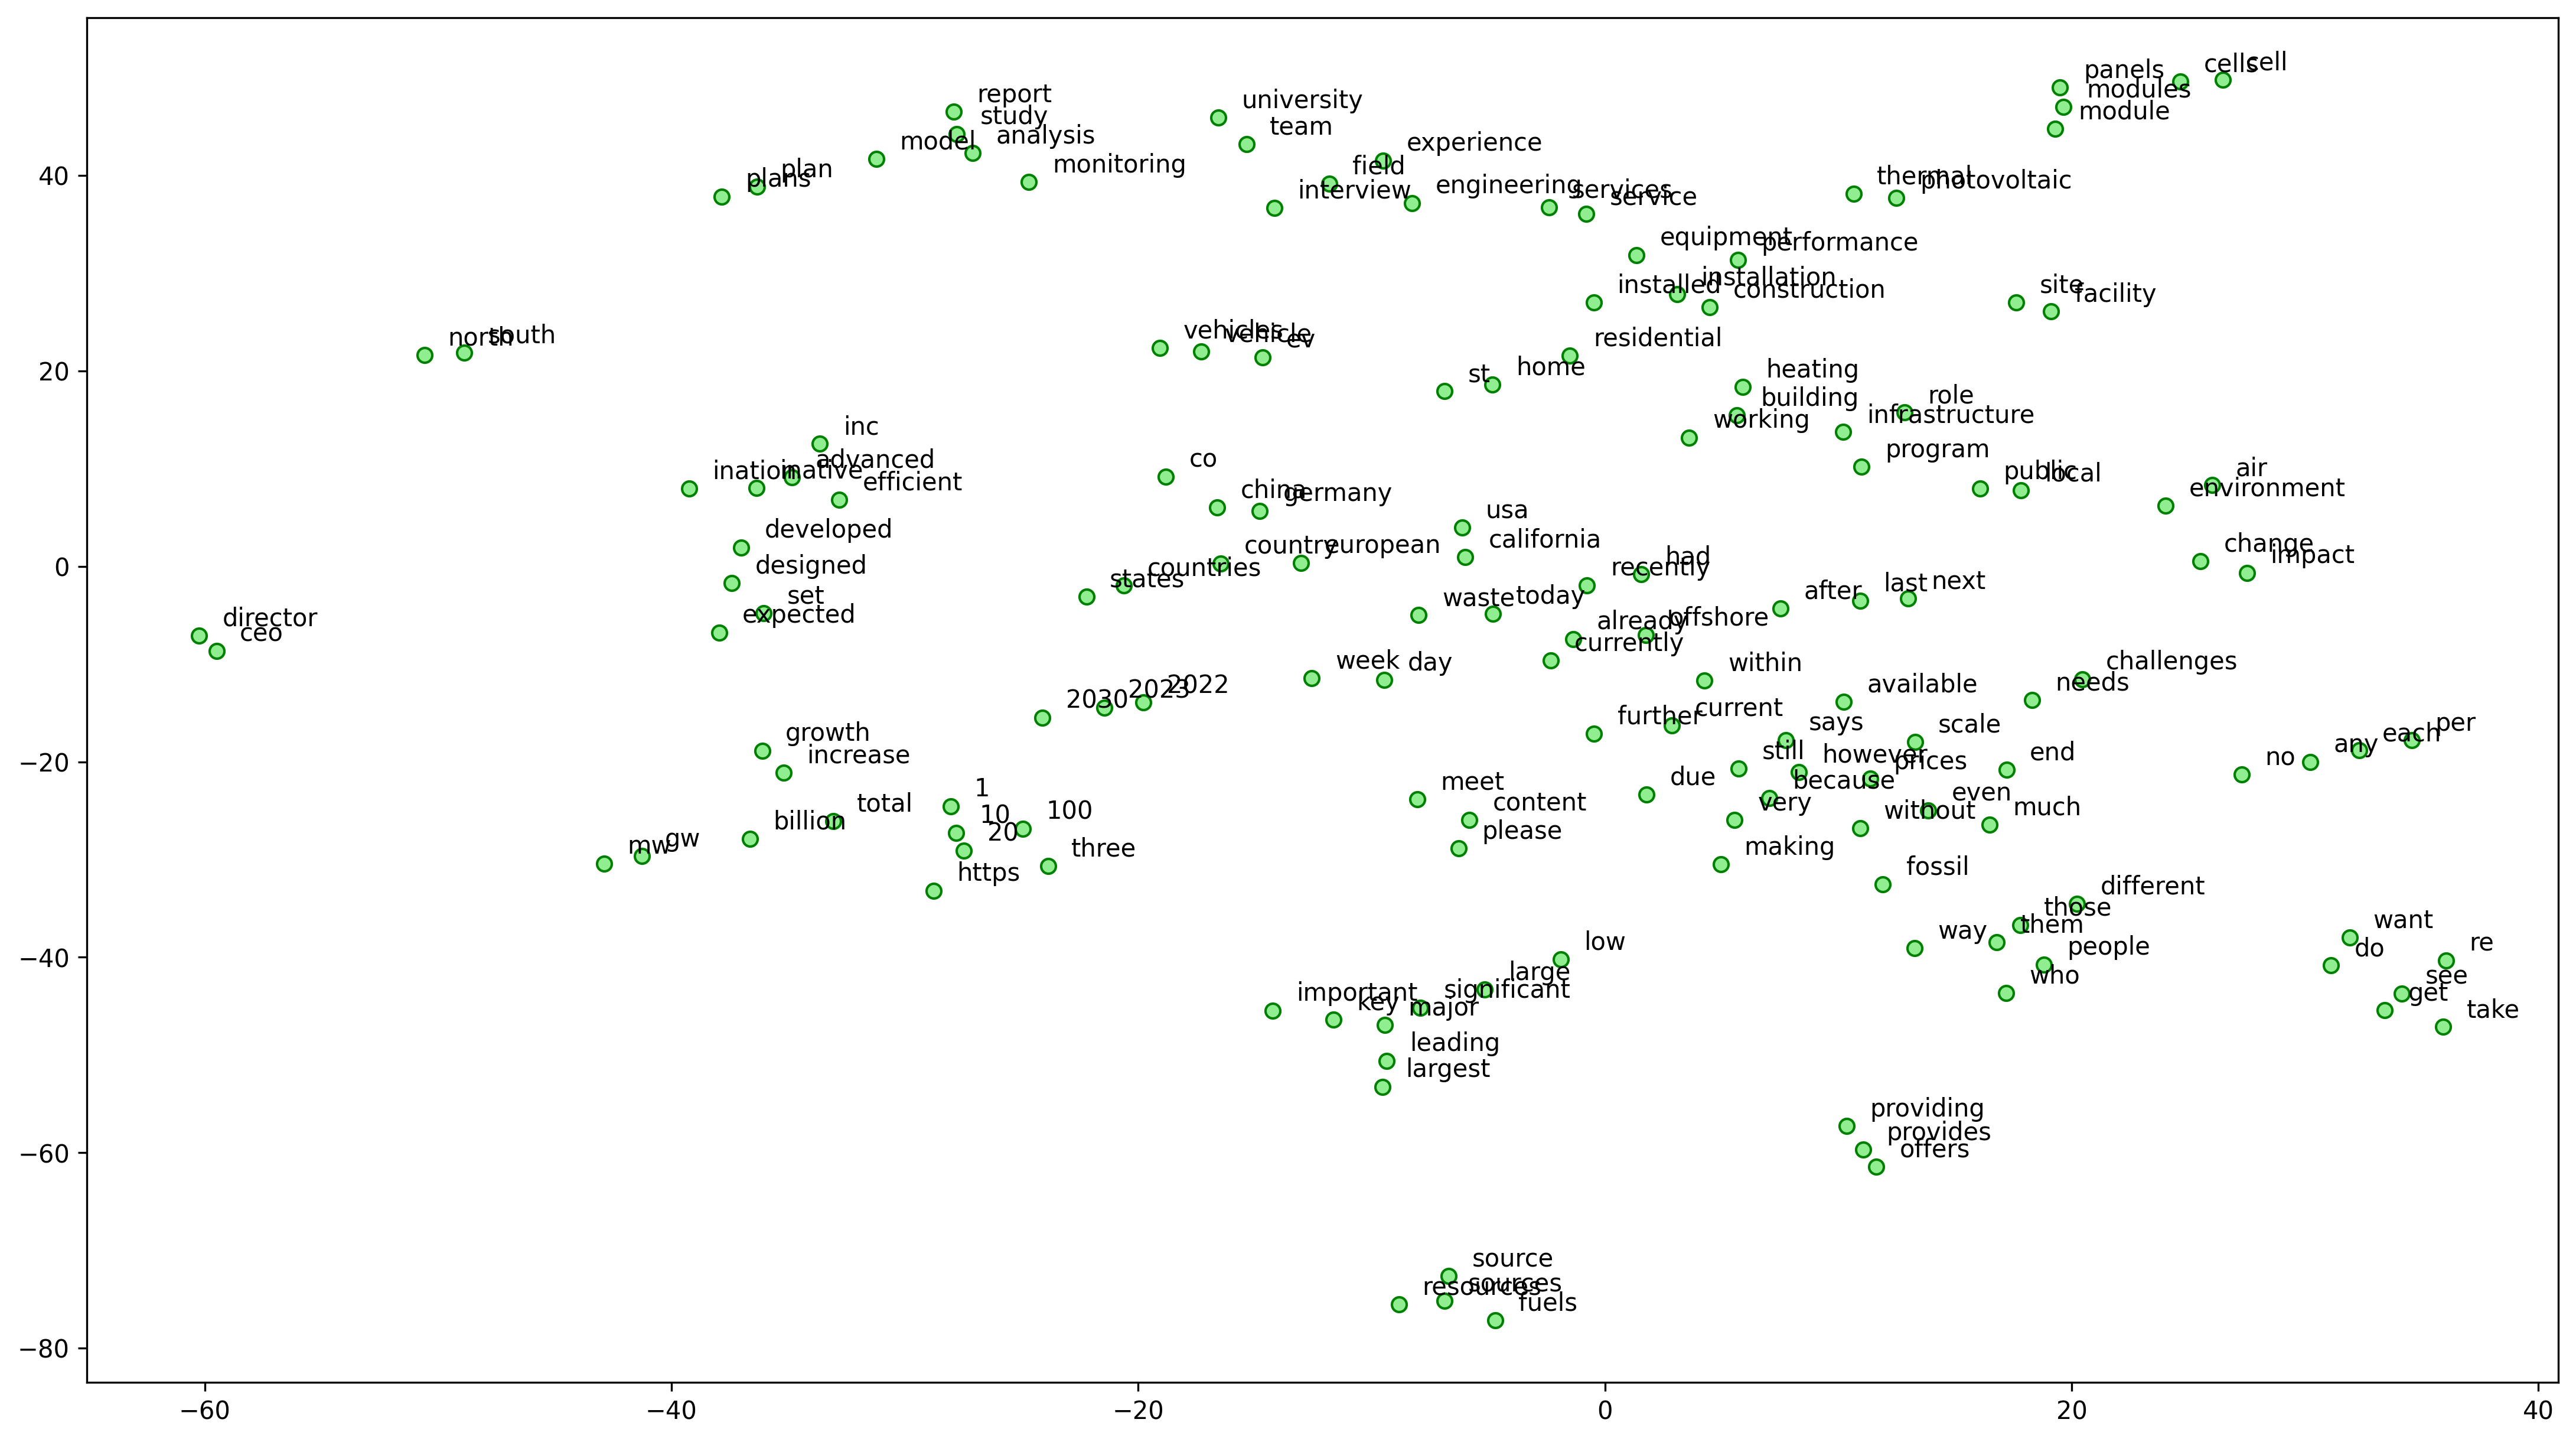

In [132]:
from sklearn.manifold import TSNE

words = w2vmodel_media_standard.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel_media_standard.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


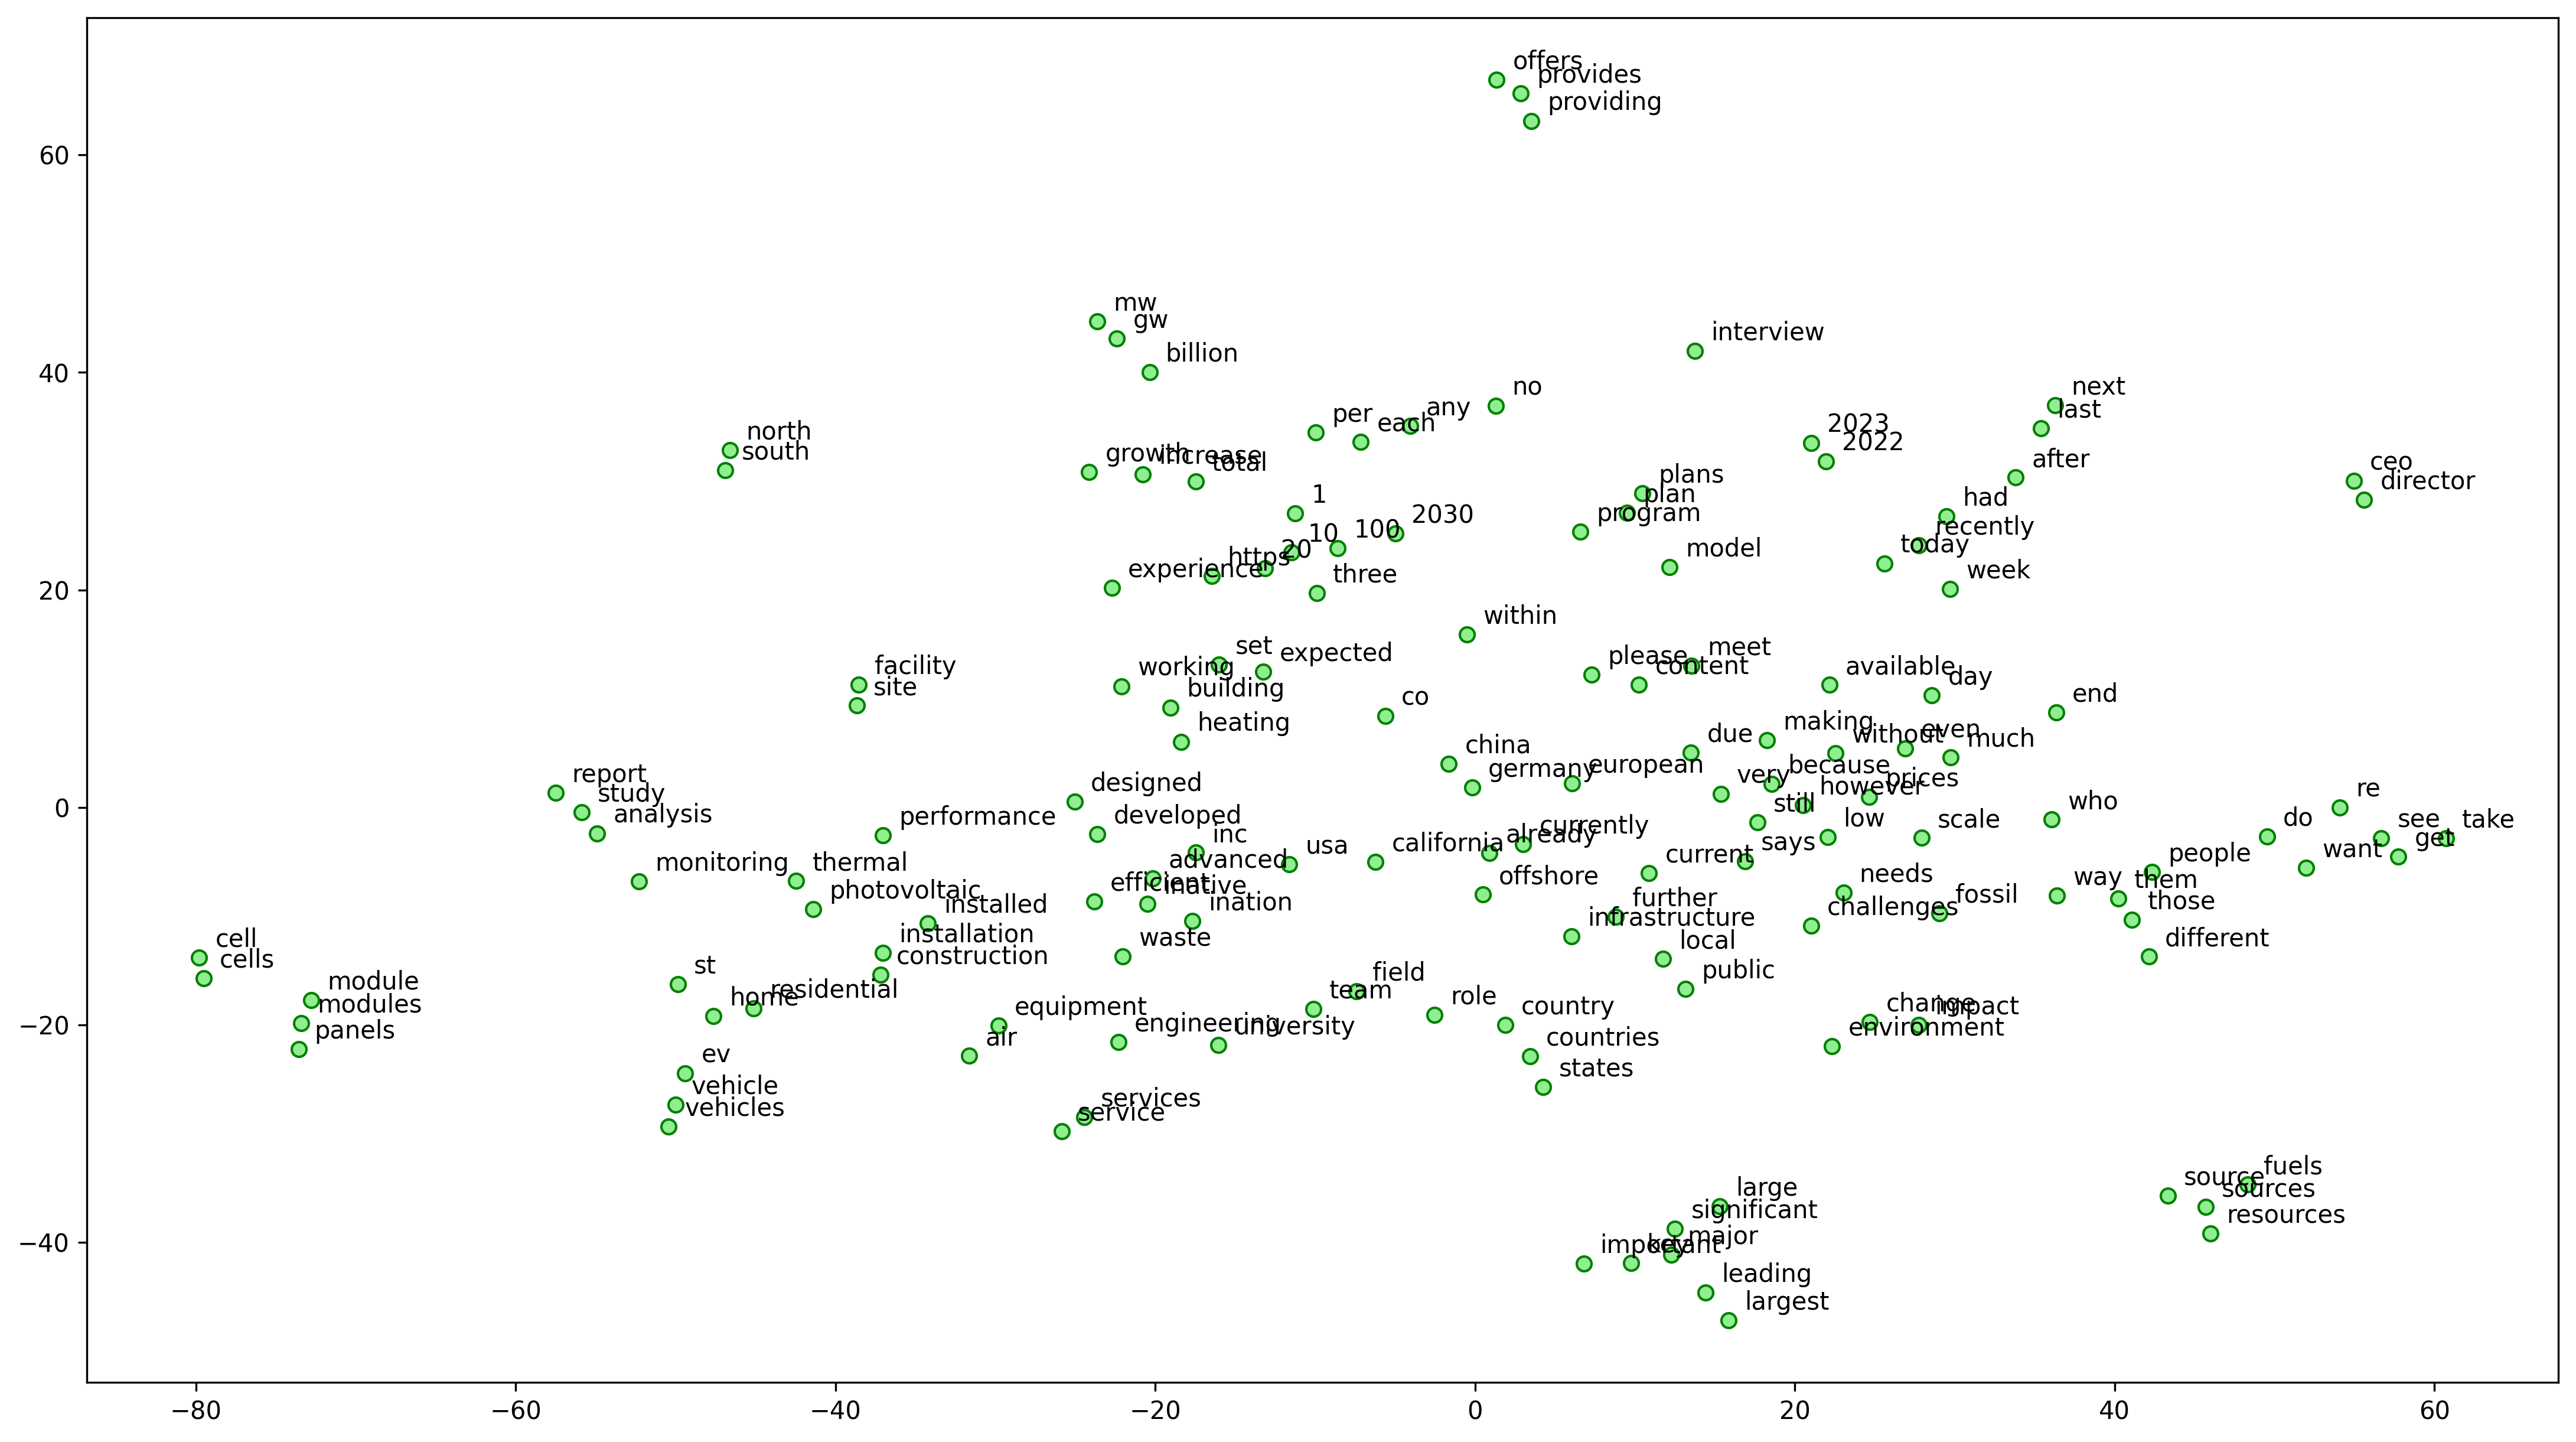

In [133]:
from sklearn.manifold import TSNE

words = w2vmodel_media_optimized.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel_media_optimized.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

**Key Observations**  
- The overall structure of both models is similar, indicating that core word relationships remain stable.  
- Some **word placements differ**, reflecting changes in how the models understand word similarity.  
- The optimized model may show a **clearer semantic structure**, but further evaluation is needed to confirm improvements in downstream tasks.  

**Conclusion**  
By keeping the sampling and visualization settings identical, we highlight the impact of **hyperparameter tuning** on word embeddings. The optimized model nor the standard provides a better visual performance,  additional testing is needed to quantify improvements beyond visualization.  

As we finished the media dataset let's now train two Word2Vec on the patent dataset

In [125]:
#Train Benchmark Model for Patent

# Set values for various parameters from example
feature_size = 100  # The dimensionality of the word vectors.
window_context = 5  # Defines the maximum distance between the current and predicted word within a sentence.
min_word_count = 5  # Ignores words that appear less than min_count times in the corpus.

w2vmodel_patent_standard = Word2Vec(sentences=df_patent['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

In [126]:
#Train Benchmark Model for Patent

# Set values for various parameters from example
feature_size = 200  # The dimensionality of the word vectors.
window_context = 7  # Defines the maximum distance between the current and predicted word within a sentence.
min_word_count = 3  # Ignores words that appear less than min_count times in the corpus.

w2vmodel_patent_optimized = Word2Vec(sentences=df_patent['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg = 1)

Now we do the same and compare the similarity similar words in the different models 

In [135]:
w2vmodel_patent_standard.wv.most_similar('energy', topn=5)

[('power', 0.6145719289779663),
 ('electricity', 0.5494726896286011),
 ('heat', 0.5201087594032288),
 ('heating', 0.4771978259086609),
 ('conversion', 0.45995739102363586)]

In [136]:
w2vmodel_patent_optimized.wv.most_similar('energy', topn=5)

[('lowquality', 0.6879629492759705),
 ('storable', 0.6810980439186096),
 ('bicycles', 0.6699875593185425),
 ('peltier', 0.6666039824485779),
 ('energyelectric', 0.6631563305854797)]

**Key Insights**

- **Patent Baseline Model:** Similar words to **"energy"** include **"power"**, **"electricity"**, and **"heat"**, reflecting conventional energy concepts.  
- **Patent Optimized Model:** Returns **"lowquality"**, **"storable"**, and **"peltier"**, indicating a shift toward niche or less expected associations.  
- **Comparison with Media Dataset:**  
  - The **Media optimized model** retains clearer energy-related terms.  
  - The **Patent optimized model** diverges more, suggesting stronger domain adaptation but potentially noisier relationships.  


The optimized **Patent model** produced unexpected similar words for **"energy"**, likely due to the following factors:  

- **Feature Size (`200`) May Be Too Small:** A higher dimensionality (**300-400**) could better capture technical term relationships.  
- **Skip-gram (`sg=1`) Overfitting to Rare Words:** May prioritize low-frequency terms, leading to noisier associations.  
- **Window Size (`7`) Too Large:** Capturing broader context may have linked distant, less relevant terms. A **smaller window (3-5)** could improve focus.  
- **Domain-Specific Language Variability:** Patent terminology varies, and **"energy"** may appear in unexpected contexts (e.g., **"peltier"**, **"bicycles"**) due to specific technical applications.  



Next step is visualizing the two models as before.

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


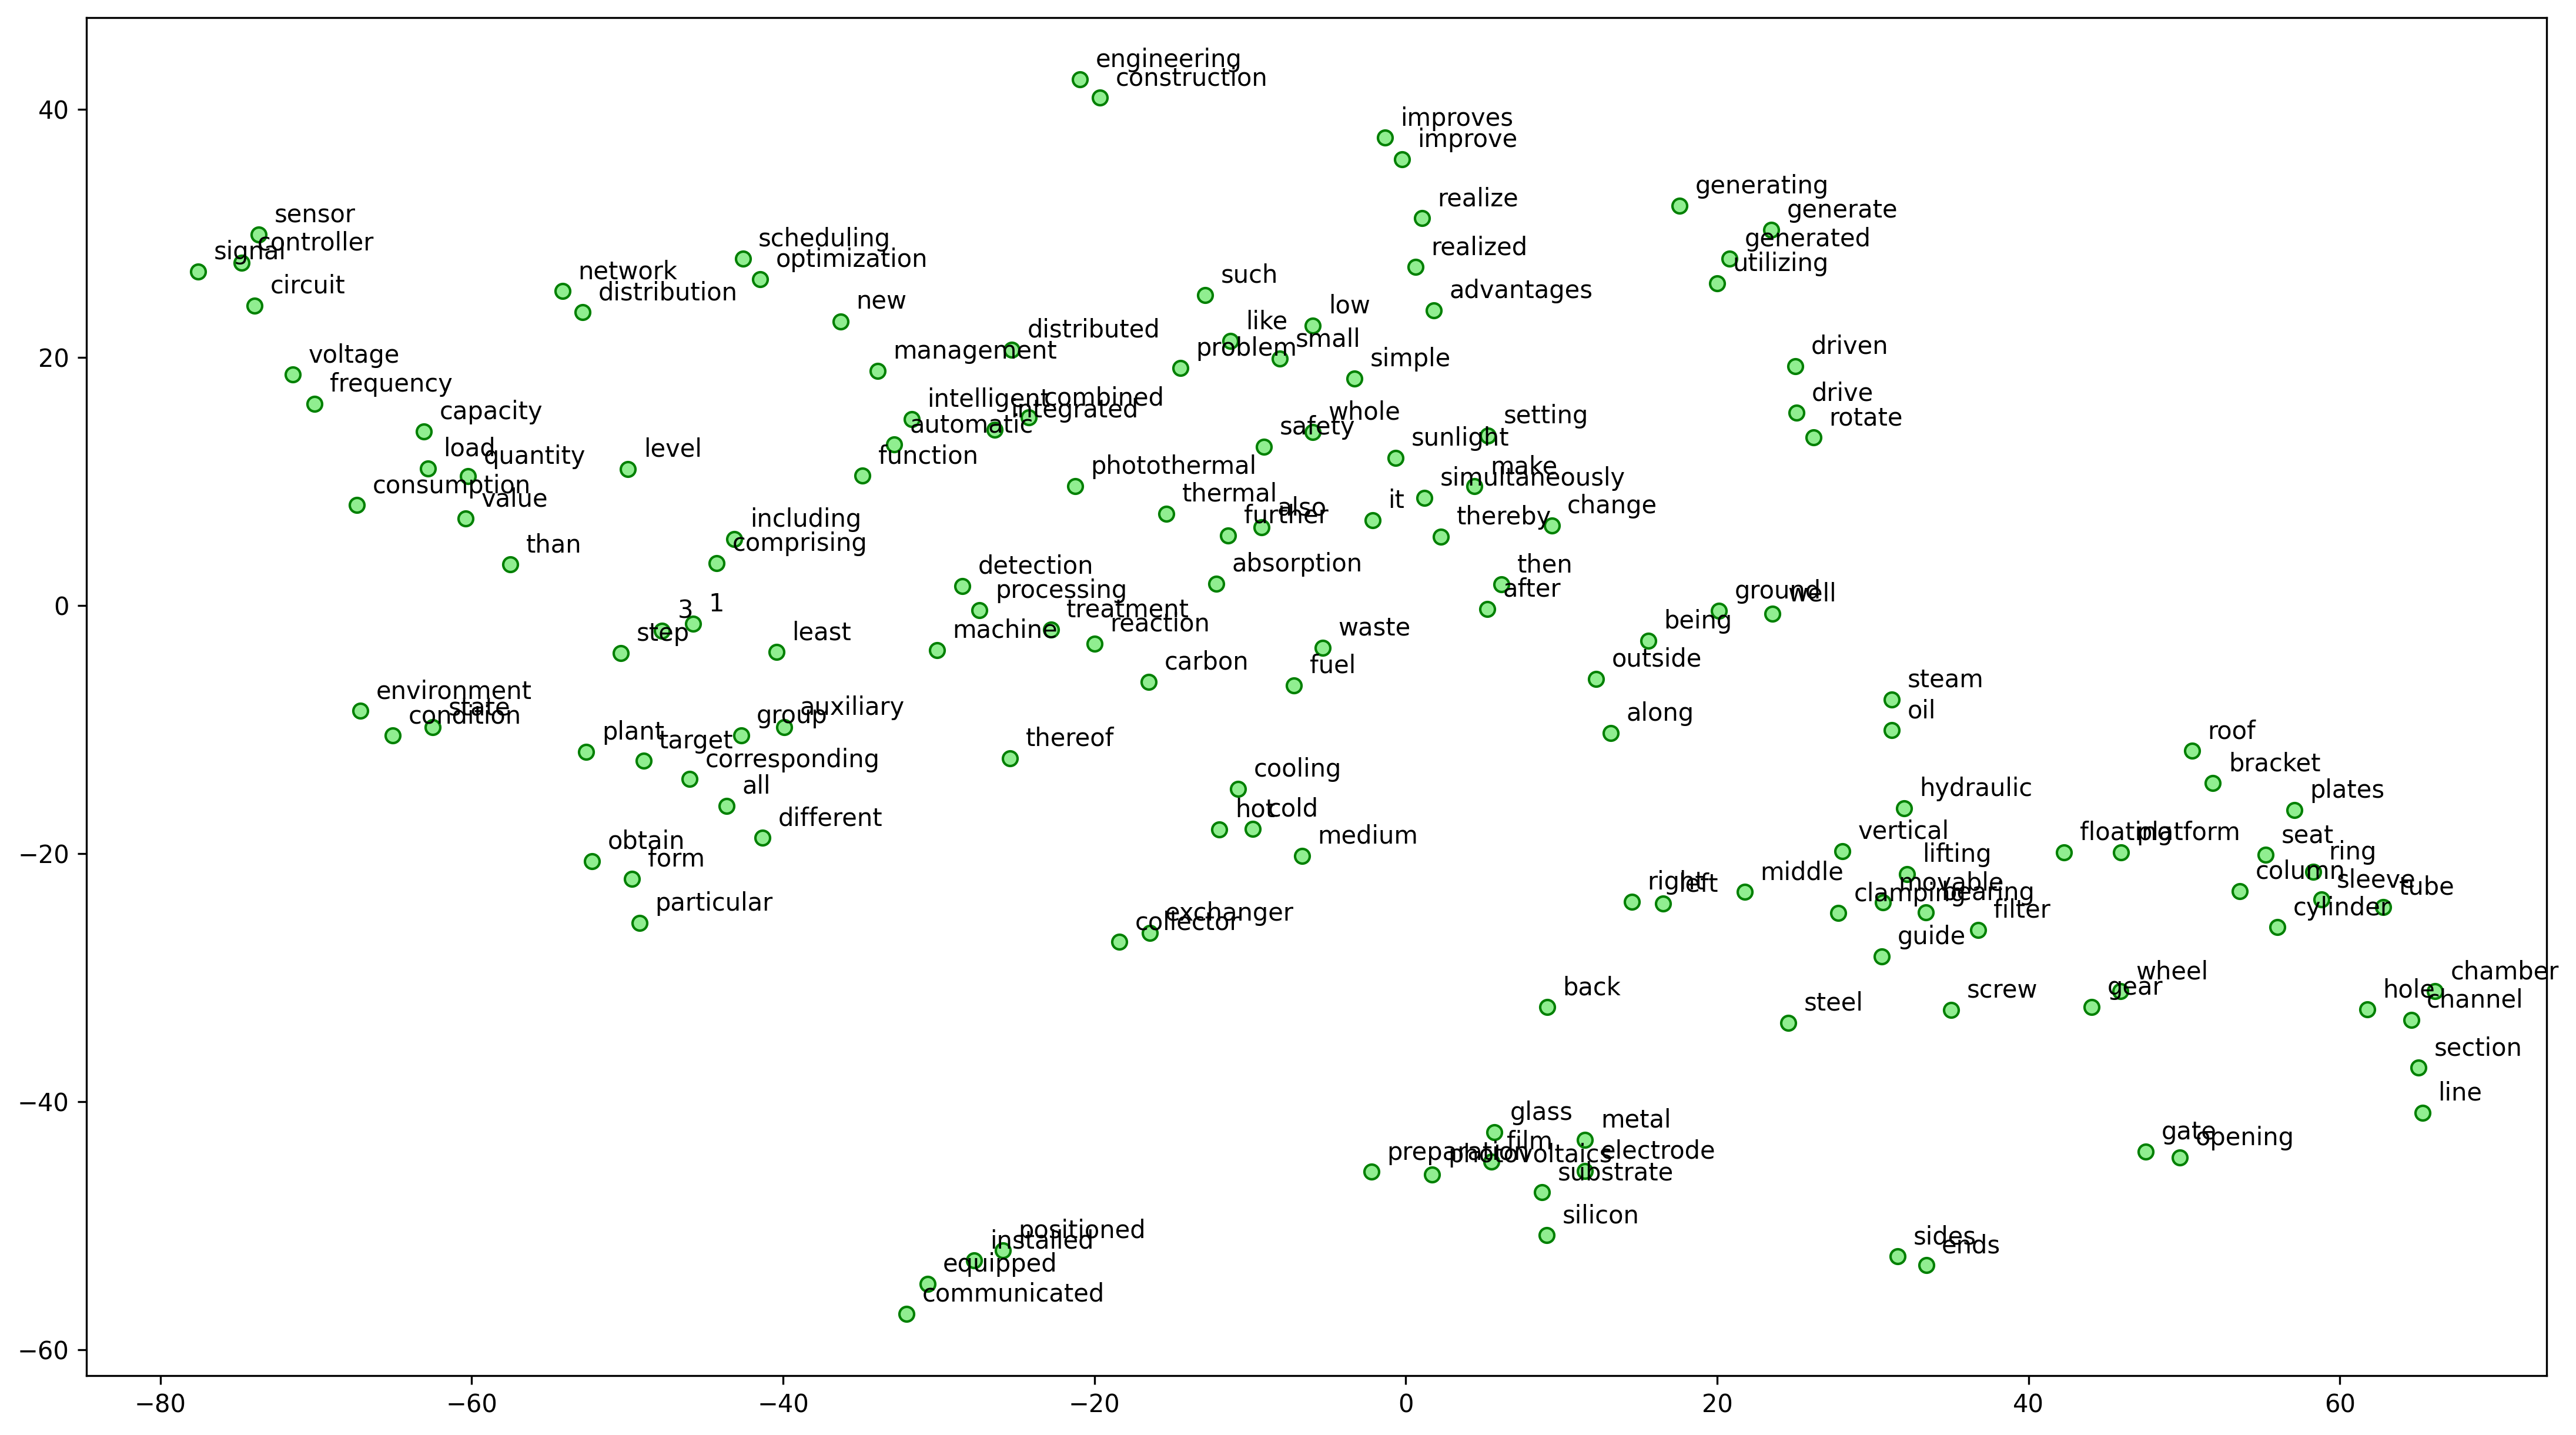

In [138]:
from sklearn.manifold import TSNE

words = w2vmodel_patent_standard.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel_patent_standard.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

c:\Users\chris\Repositories\computational-language-technology-project\.conda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


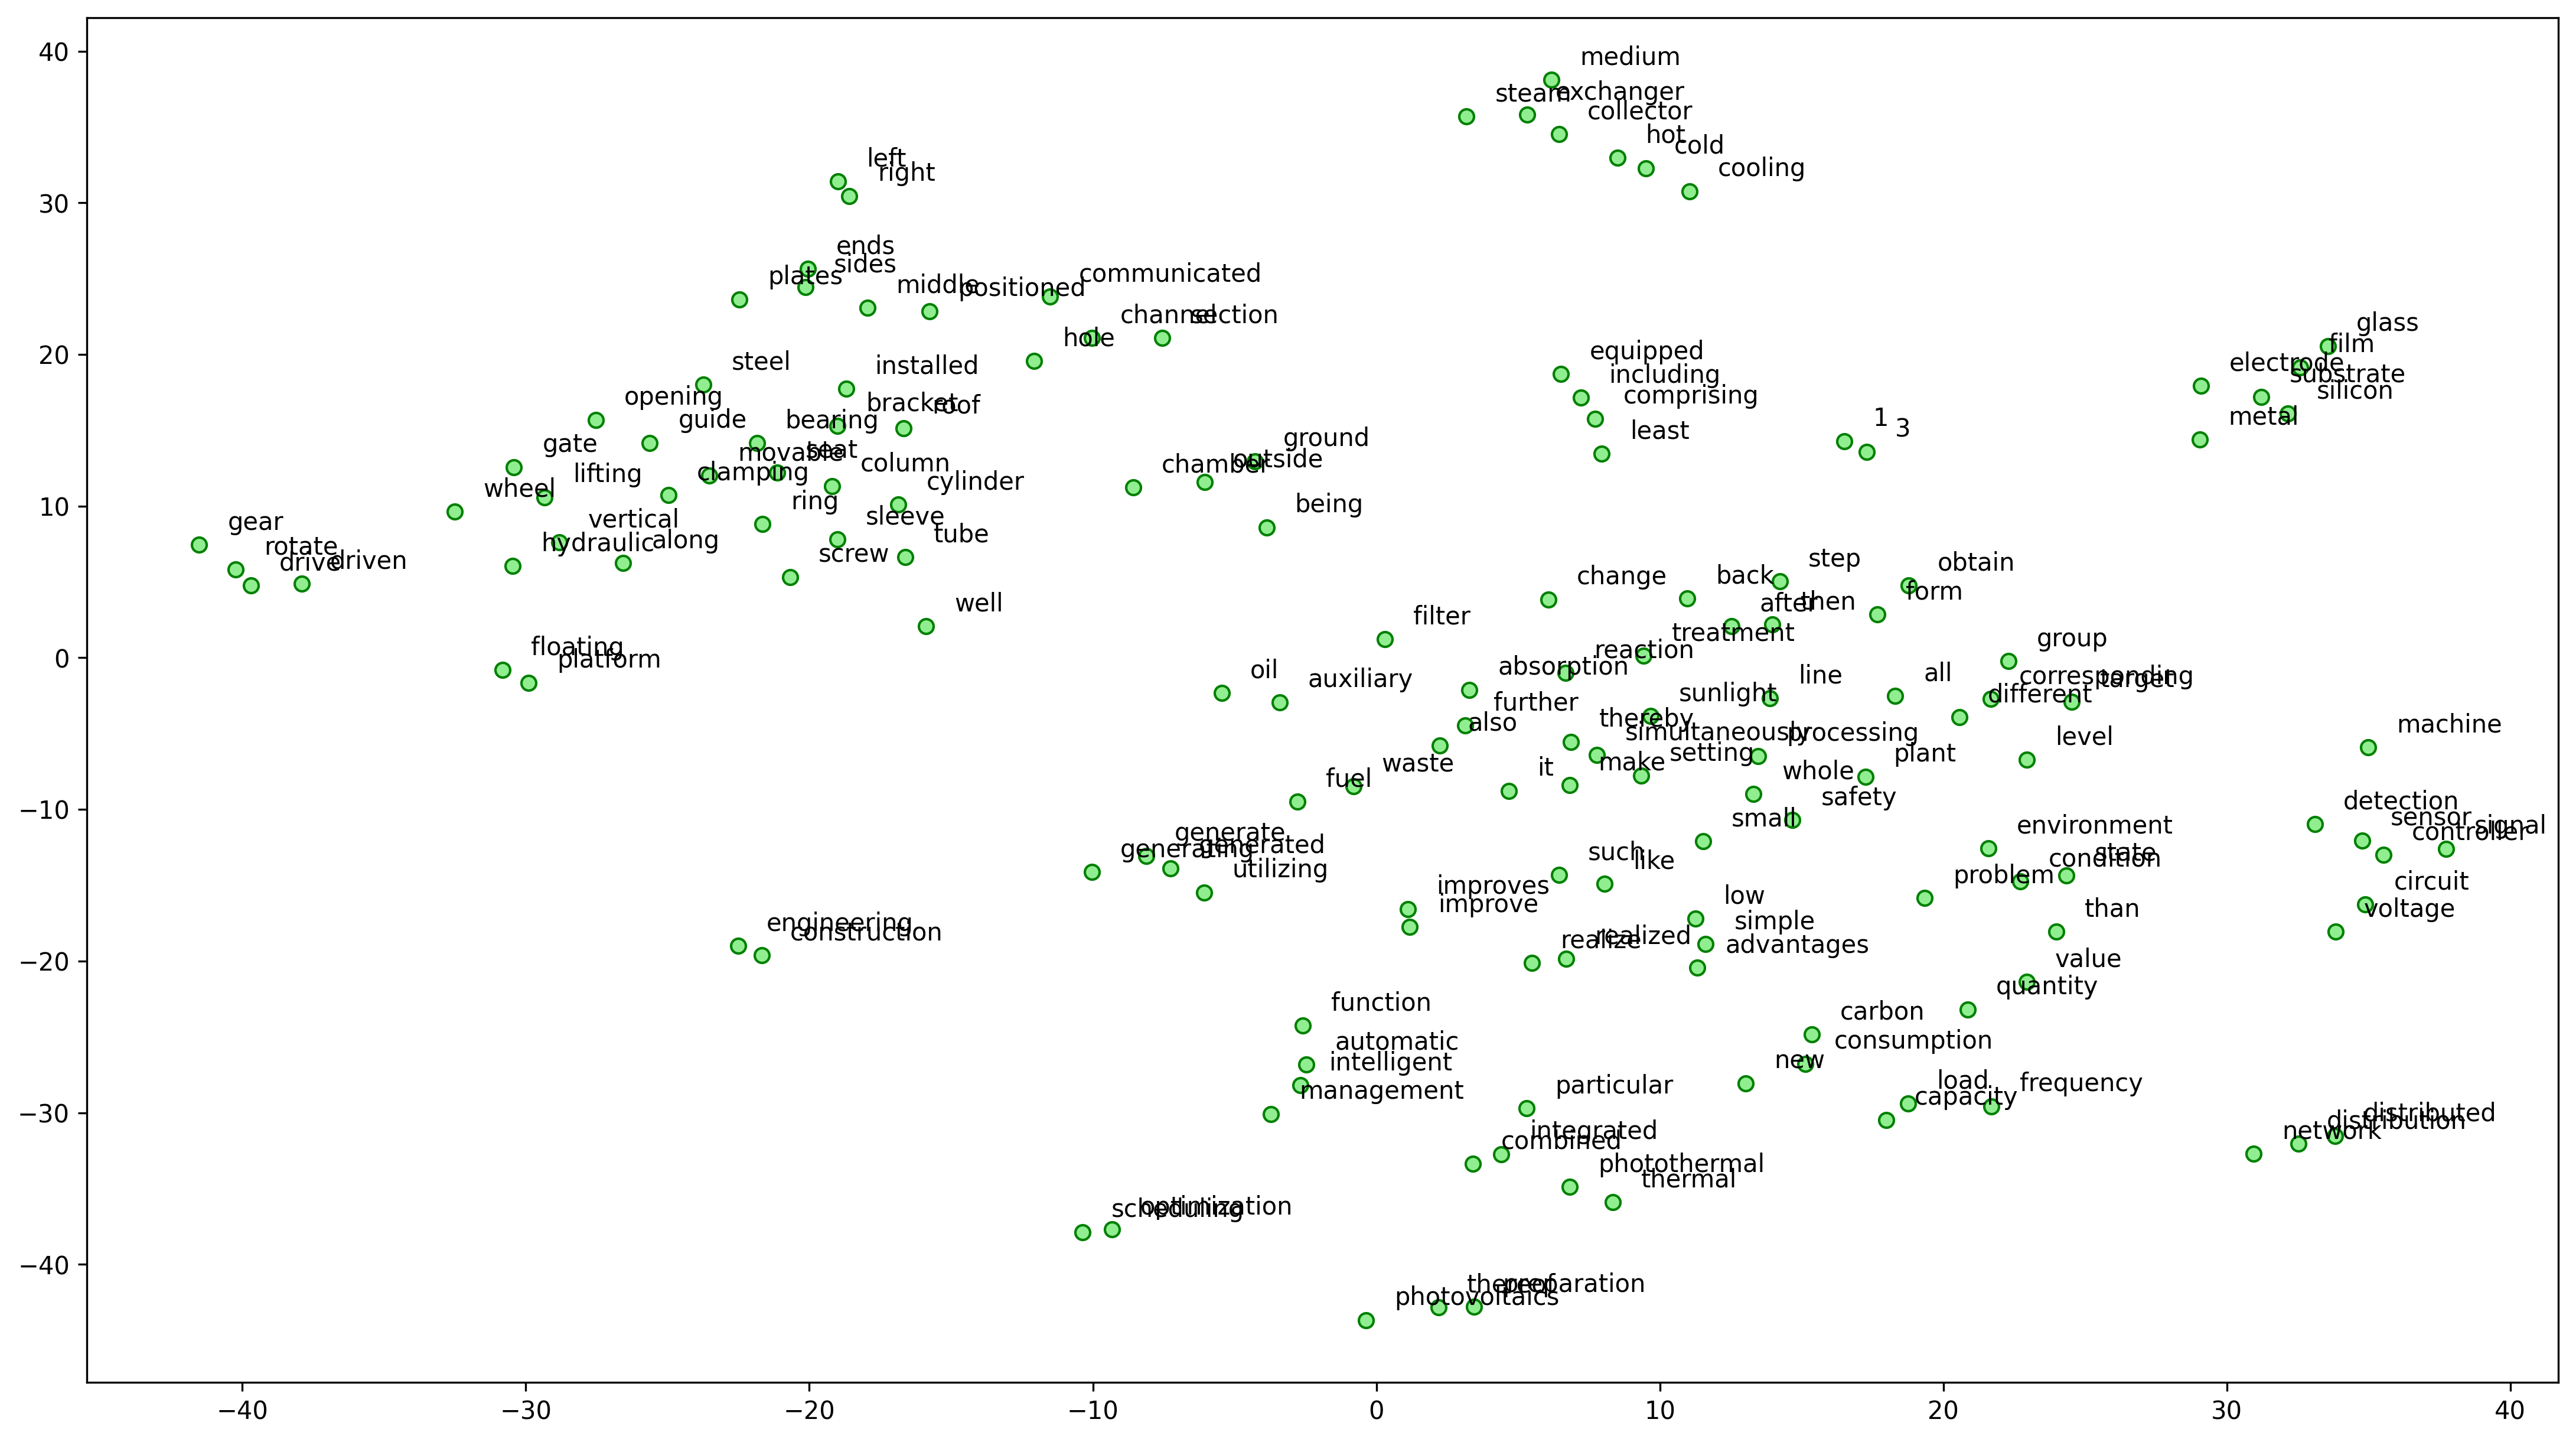

In [137]:
from sklearn.manifold import TSNE

words = w2vmodel_patent_optimized.wv.index_to_key[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel_patent_optimized.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

**Key Insights from Patent Dataset Visualization**
- **Baseline Model (Left):**  
  - Words appear **more loosely scattered**, with **some structure** but less distinct clusters.  

- **Optimized Model (Right):**  
  - Clusters are **more defined**, indicating better **semantic separation**.  
  - Some unrelated words may still appear close, likely due to **overfitting to rare terms (Skip-gram)**.  

## Sentence Embedding Training
- Use the trained embeddings to explore thematic overlaps and differences between the two datasets and identify unique insights and innovation gaps.

The next we used is the **Doc2Vec**. It is an extension of Word2Vec that generates fixed-length vector representations for entire documents. It works by training a neural network to predict words using both word context and a unique document ID.

There are two main approaches:

- **Distributed Memory (DM):** Uses context words + document ID to predict target words.
- **Distributed Bag of Words (DBOW):** Uses only the document ID to predict random words from the document.

These learned document vectors capture the semantic meaning of texts and can be used for tasks like classification, clustering, and similarity search.


First, we again train a basline model and afterwords we train an optimized Doc2Vec

In [ ]:

# Function to tag documents (data is already tokenized)
def tag_documents(data, label_prefix):
    return [TaggedDocument(words=doc, tags=[f"{label_prefix}_{i}"]) for i, doc in enumerate(data)]

#Load datasets (Assuming 'df_media' and 'df_patent' contain tokenized text)
media_documents = tag_documents(df_media_tl['tokens'], "media")
patent_documents = tag_documents(df_patent_tl['tokens'], "patent")

#BASELINE MODEL (DEFAULT PARAMETERS) ###
def train_baseline_doc2vec(tagged_data, model_name):
    model = Doc2Vec(vector_size=100, window=5, min_count=5, workers=4, epochs=10, dm=1)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.save(model_name)
    return model

# Train baseline models
doc2vec_media_baseline = train_baseline_doc2vec(media_documents, "doc2vec_media_baseline.model")
doc2vec_patent_baseline = train_baseline_doc2vec(patent_documents, "doc2vec_patent_baseline.model")

#OPTIMIZED MODEL (TUNED HYPERPARAMETERS) ###
def train_optimized_doc2vec(tagged_data, model_name):
    model = Doc2Vec(vector_size=200, window=7, min_count=3, workers=4, epochs=20, dm=1, alpha=0.025)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.save(model_name)
    return model

# Train optimized models
doc2vec_media_optimized = train_optimized_doc2vec(media_documents, "doc2vec_media_optimized.model")
doc2vec_patent_optimized = train_optimized_doc2vec(patent_documents, "doc2vec_patent_optimized.model")


In the next section we check how good the model performs.

In [47]:
# Function to retrieve and print the closest 3 sentences
def most_similar_sentences(model, test_sentence, dataset, topn=3):
    vector = model.infer_vector(test_sentence)
    similar_docs = model.dv.most_similar([vector], topn=topn)

    print("\nClosest Sentences:")
    for doc_tag, similarity in similar_docs:
        # Extract the numeric index from the tag (e.g., 'media_15016' → 15016)
        doc_index = int(doc_tag.split("_")[1])
        
        # Retrieve and print the corresponding sentence
        print(f"Similarity: {similarity:.4f} → {doc_tag} → {' '.join(dataset.iloc[doc_index])}")

# Define a sample test sentence
sample_sentence = ["energy", "efficiency", "renewable"]

# Retrieve and print closest sentences for each model
print("\n Media Baseline Model")
most_similar_sentences(doc2vec_media_baseline, sample_sentence, df_media['tokens'])

print("\n Media Optimized Model")
most_similar_sentences(doc2vec_media_optimized, sample_sentence, df_media['tokens'])

print("\n Patent Baseline Model")
most_similar_sentences(doc2vec_patent_baseline, sample_sentence, df_patent['tokens'])

print("\n Patent Optimized Model")
most_similar_sentences(doc2vec_patent_optimized, sample_sentence, df_patent['tokens'])



 Media Baseline Model

Closest Sentences:
Similarity: 0.8607 → media_7060 → arcadia biosciences develops and commercializes agriculturebased technologies that create value for growers and consumers while benefiting the environment and enhancing human health the sensi(tm ) is a laserbased analyzer used for monitoring natural gas quality the cypher es afm from oxford instruments asylum research can be utilized for exceptional environmental control the vocus citof from tofwerk provides realtime chemical ionization measurements in this interview azocleantech speaks with tebogo maleka national project coordinator at the united nations industrial development organization unido about her role within the organization and the initiative that aims to support south africas transition from conventional plastics to more environmentally sustainable alternatives azocleantech recently spoke to entrepreneur sian sutherland the cofounder of a plastic planet for international womens day her companys goa

## **Key Findings**  


### **Media Dataset**  
- **Baseline Model:** Retrieved sentences with **high similarity (0.86–0.84)** but often contained repeated content (e.g. cypher) suggesting **overfitting to frequent phrases**.  
- **Optimized Model:** Showed **slightly lower similarity scores (0.81–0.79)** but retrieved **more diverse and contextually relevant** sentences.  

### **Patent Dataset**  
- **Baseline Model:** Retrieved sentences with **moderate similarity (0.56–0.51)** but often included **long, complex patent descriptions**, indicating that embeddings may not effectively capture key information.  
- **Optimized Model:** Achieved **slightly higher similarity (0.58–0.56)** and may retrieved **more structured, relevant technical descriptions**, may improving domain-specific sentence matching.  



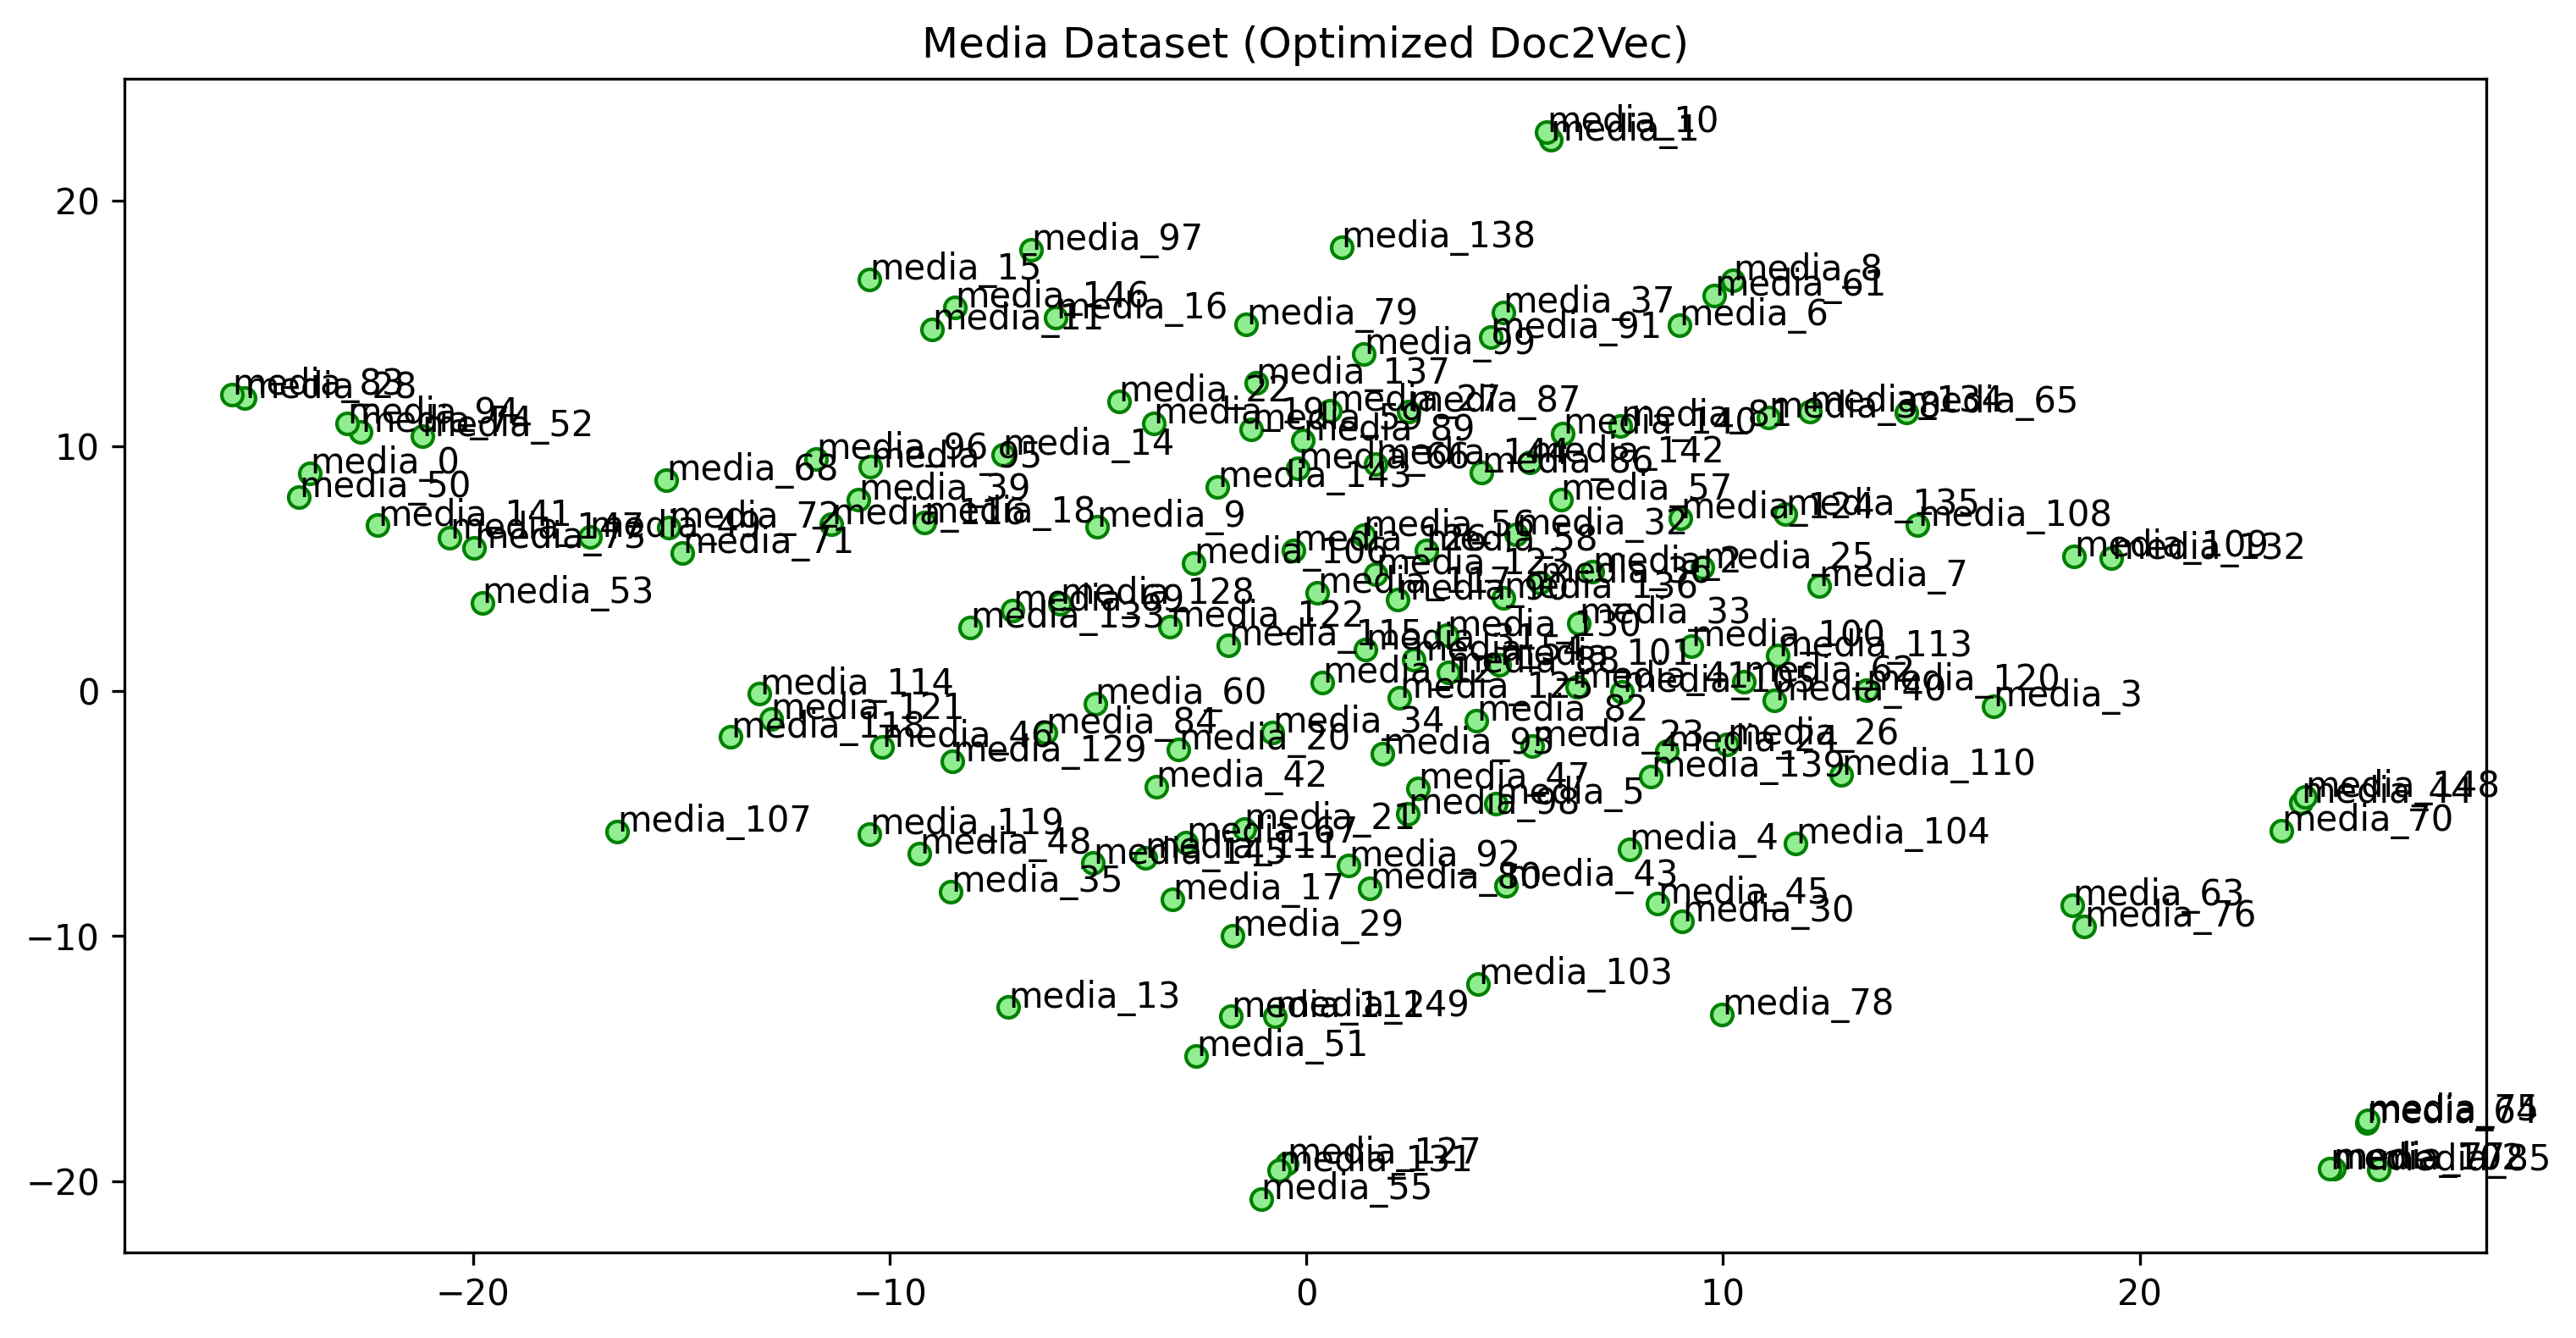

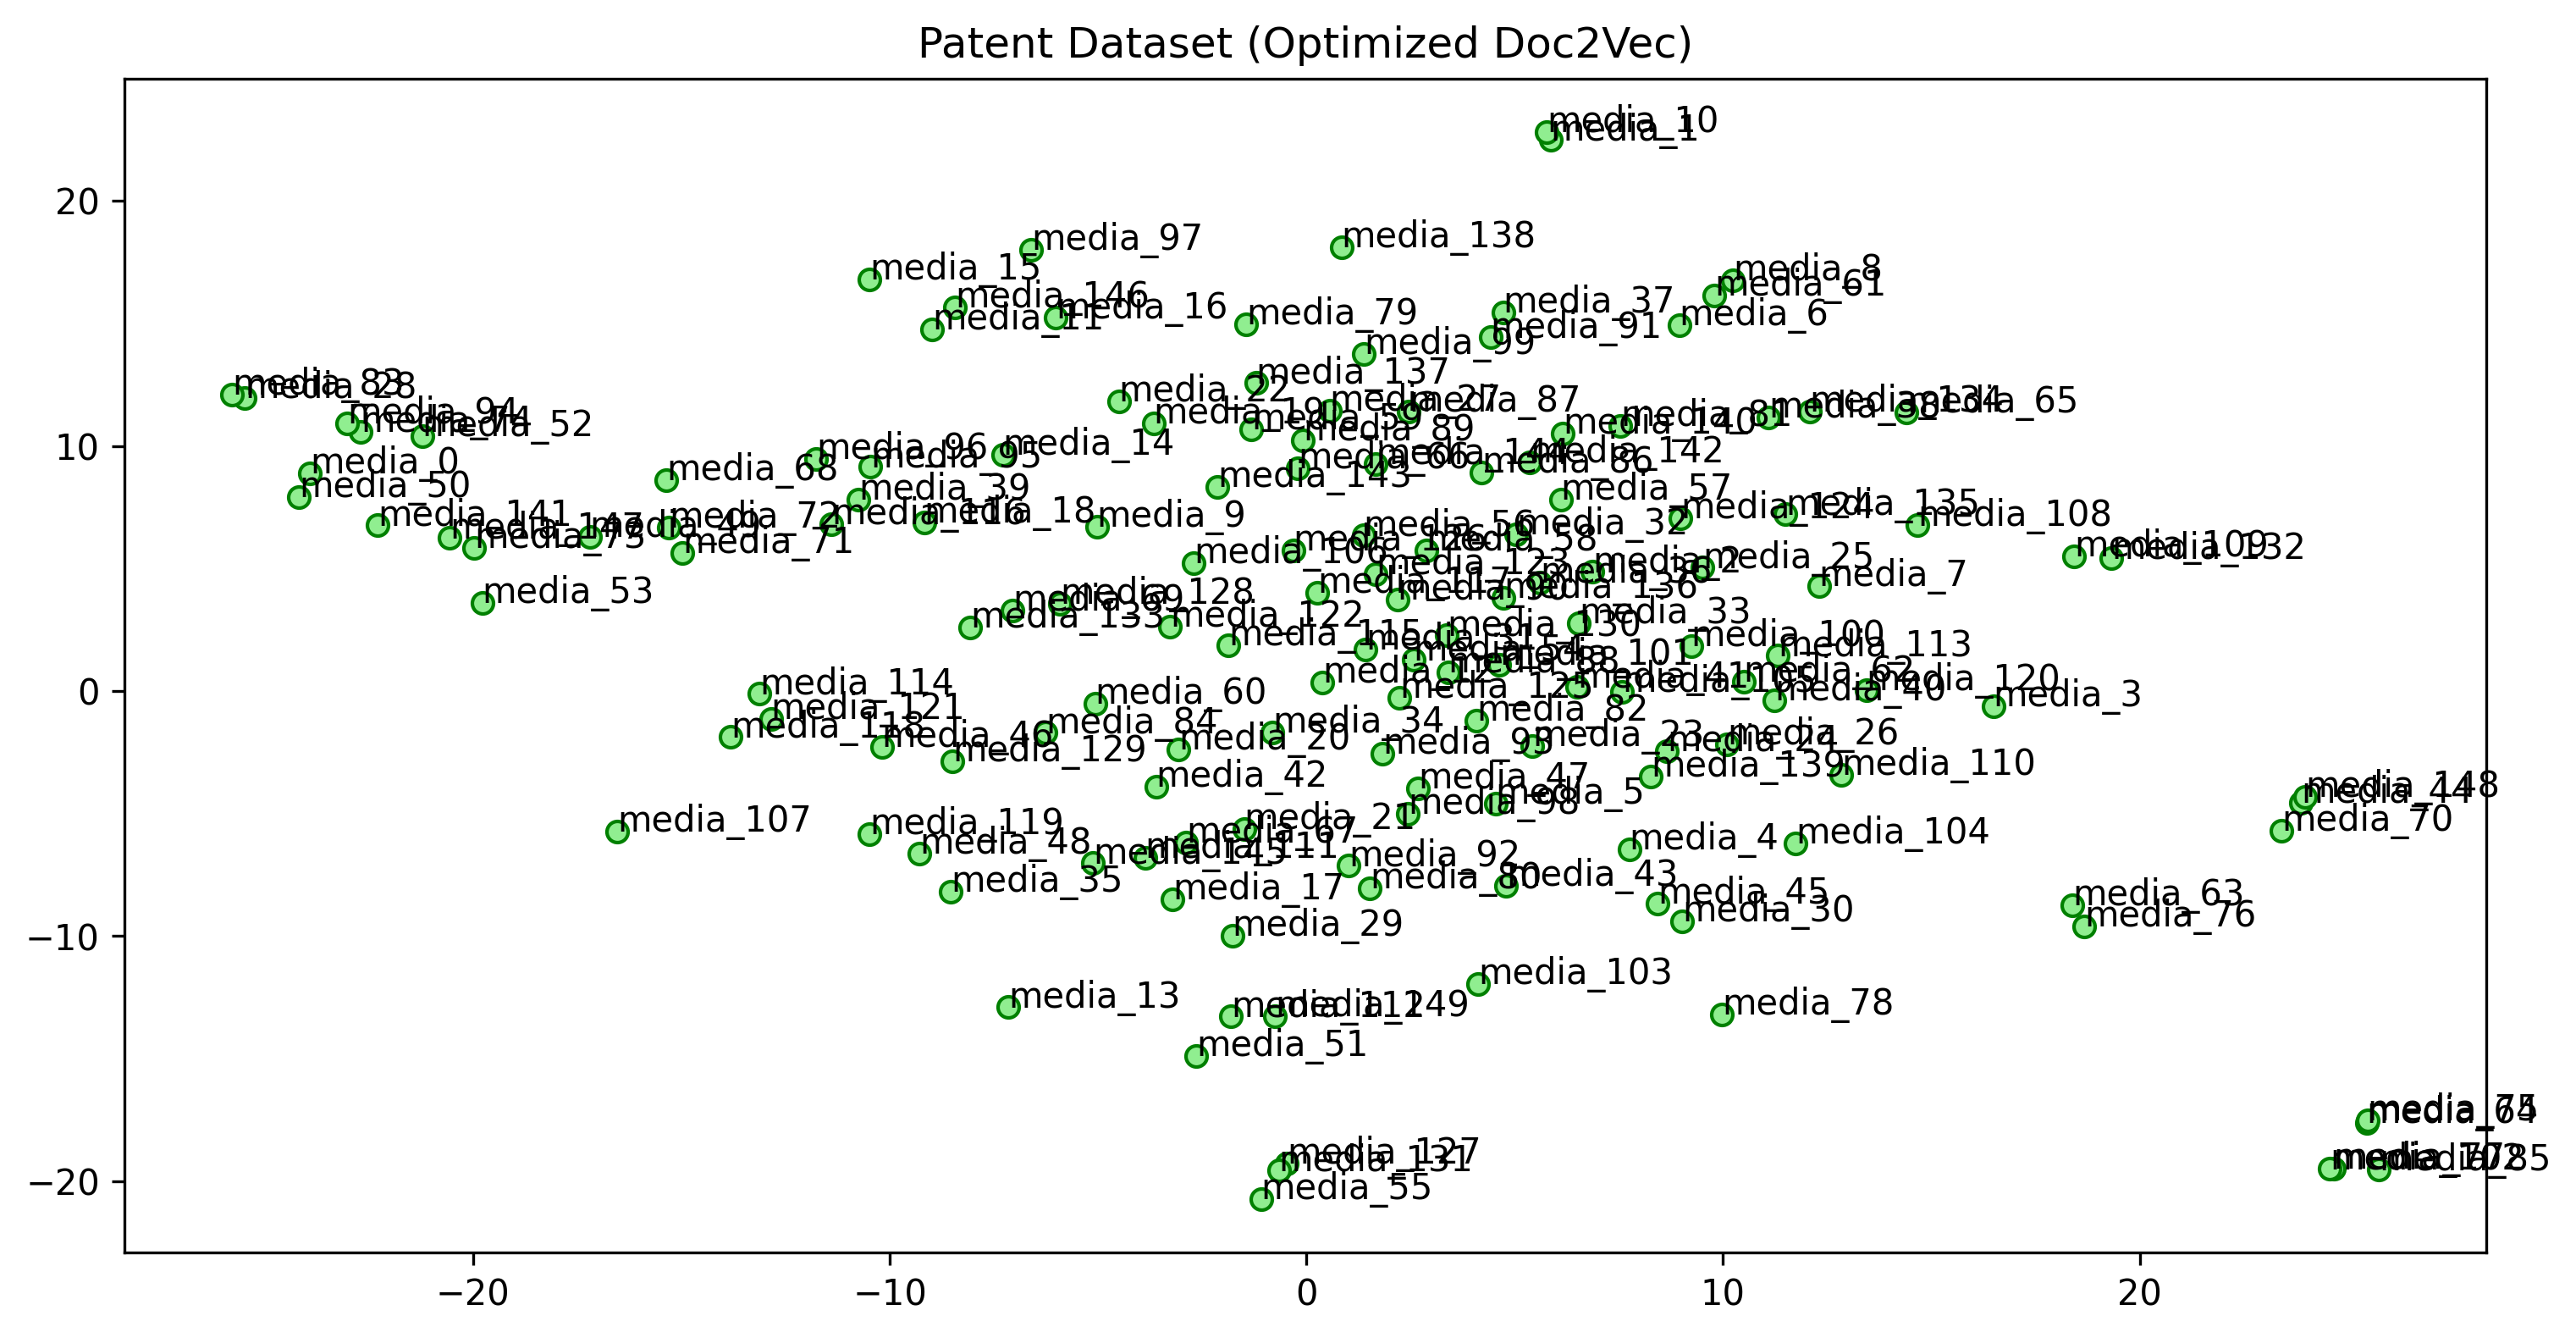

In [50]:
### VISUALIZATION: CLUSTERING EMBEDDINGS WITH T-SNE ###

def visualize_embeddings(model, title):
    words = model.dv.index_to_key[:150]  # Get top 150 documents
    vectors = np.array([model.dv[word] for word in words])

    tsne = TSNE(n_components=2, random_state=0, perplexity=5)
    transformed_vectors = tsne.fit_transform(vectors)

    plt.figure(figsize=(12, 6))
    plt.scatter(transformed_vectors[:, 0], transformed_vectors[:, 1], c='lightgreen', edgecolors='g')
    for label, x, y in zip(words, transformed_vectors[:, 0], transformed_vectors[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
    plt.title(title)
    plt.show()

# Visualizing embeddings
visualize_embeddings(doc2vec_media_optimized, "Media Dataset (Optimized Doc2Vec)")
visualize_embeddings(doc2vec_media_optimized, "Patent Dataset (Optimized Doc2Vec)")



**Key Findings from Visual Comparison of Media Models**
- **Baseline Model**: Forms **highly compact and fragmented clusters**, likely overfitting to frequent terms rather than generalizing semantic meaning.  
- **Optimized Model**: Produces **fewer, more smoothly distributed clusters**, capturing broader relationships between documents.  
- **Comparison**: The baseline model may be **better for strict topic separation**, while the optimized model **generalizes document meanings more effectively**.  


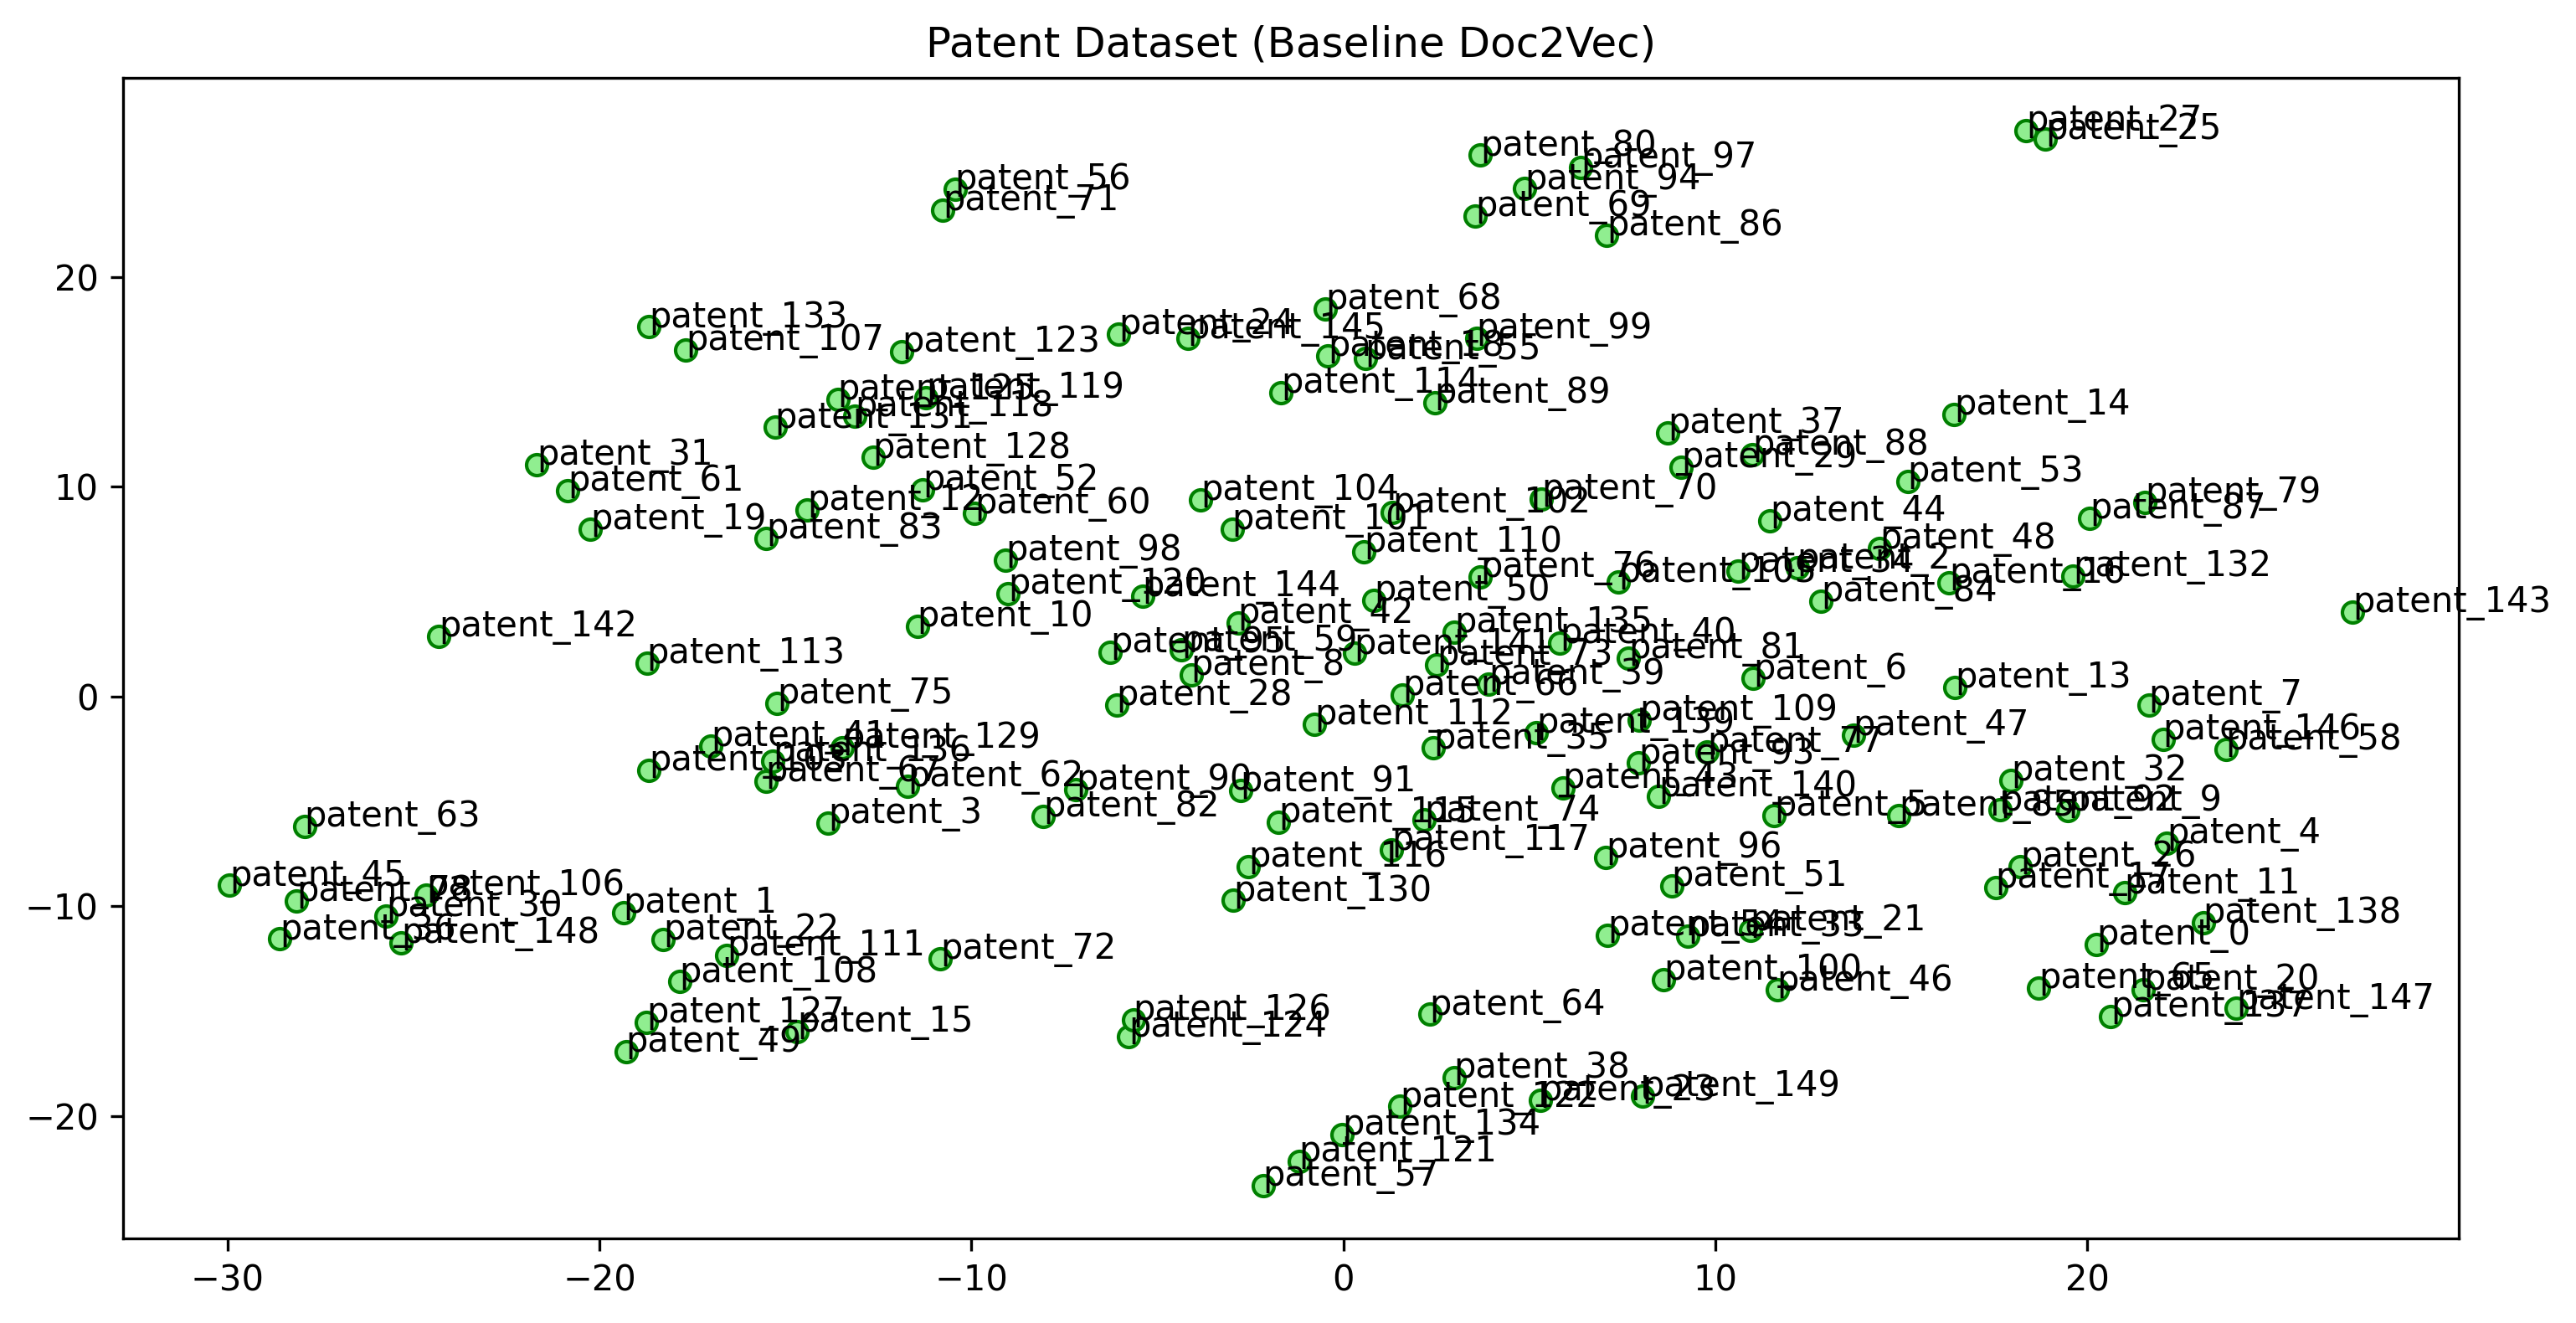

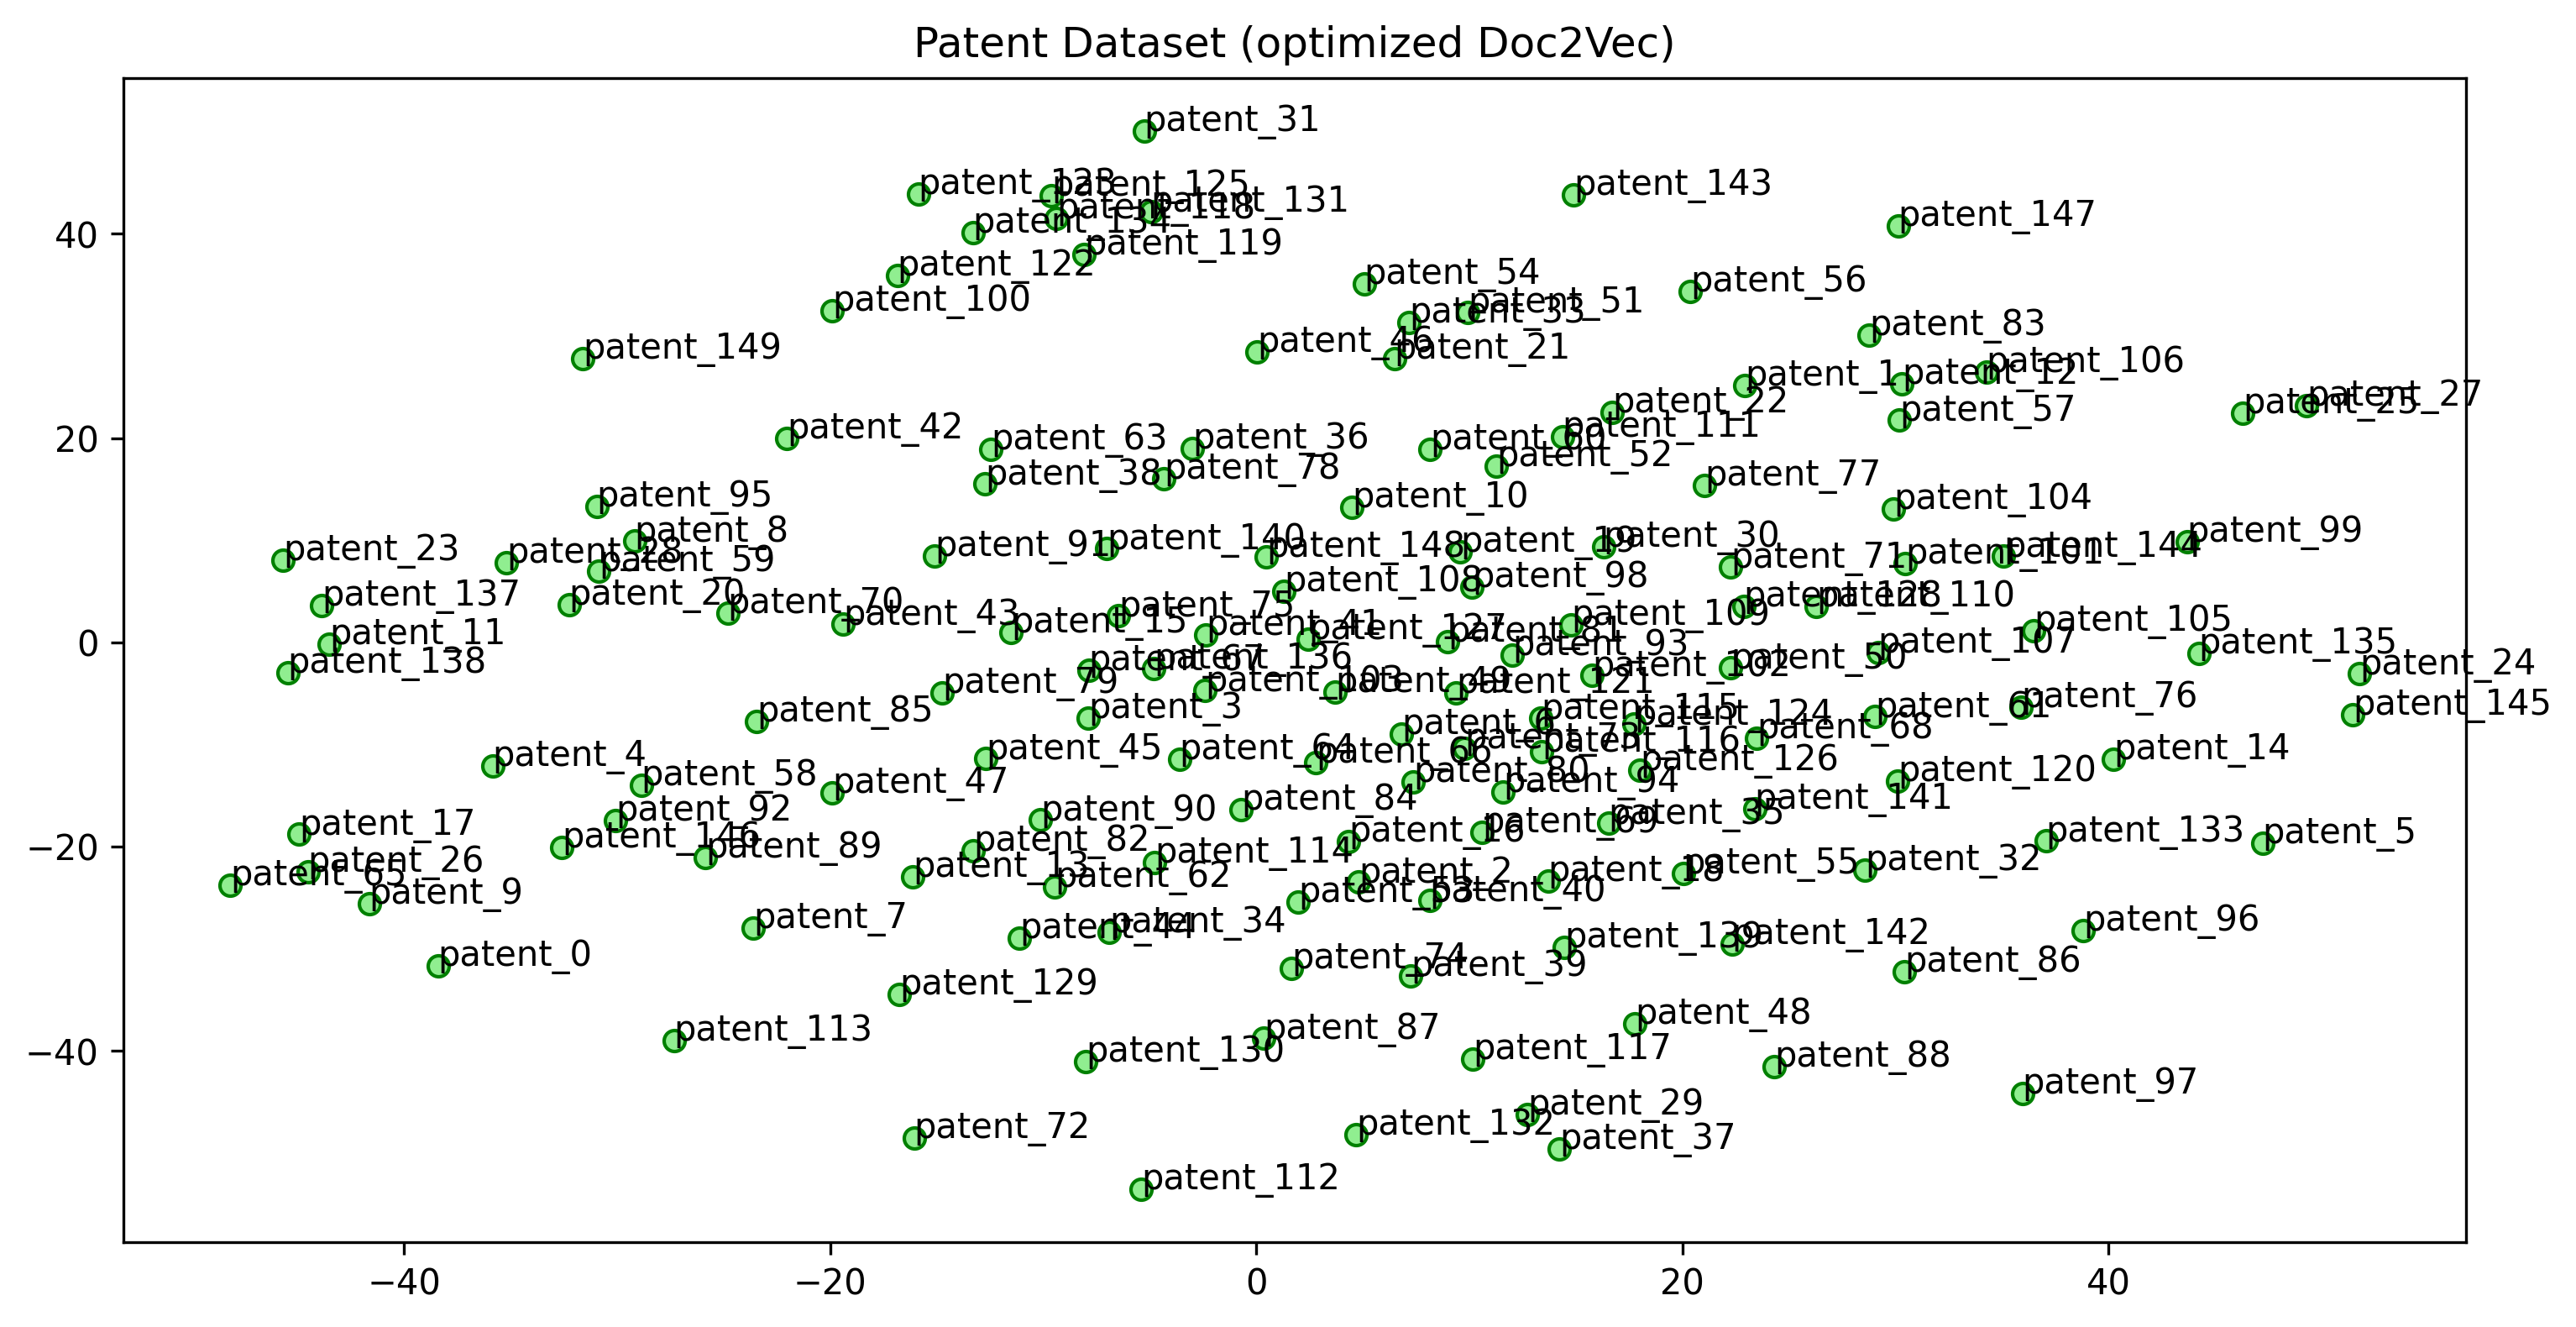

In [52]:
# Visualizing embeddings
visualize_embeddings(doc2vec_patent_baseline, "Patent Dataset (Baseline Doc2Vec)")
visualize_embeddings(doc2vec_patent_optimized, "Patent Dataset (optimized Doc2Vec)")

**Key Findings from the Patent Dataset Visualization**

- **Baseline Model:** Forms some **compact, distinct clusters**, showing strong topic separation but potentially overfitting to specific terms.  
- **Optimized Model:** Displays **fewer clusters** and a **more evenly distributed space**, capturing **broader relationships** rather than enforcing rigid separations.  
- **Comparison:** The baseline model **differentiates topics more strictly**, while the optimized model **generalizes better**, making it **more flexible for search and retrieval tasks**.  

To further evaluate the embeddings, we recommend **quantitative cluster validation** using **Silhouette Score** or  applying **K-Means clustering** to compare compactness. Additionally, experimenting with **larger feature sizes** and conducting a **nearest neighbor analysis** could provide deeper insights into the quality of the learned representations.  

 


## Transfer Learning with Advanced Open-Source Models
- Implement transfer learning by fine-tuning pre-trained open-source models such as RoBERTa, XLNet, Longformer, FLAN-T5, and BART on the text data. Evaluate the model performance using intrinsic measures (e.g., word similarity, clustering quality) before and after fine-tuning. Analyze and quantify the insights gained from the fine-tuned model regarding emerging trends and innovation gaps in cleantech.
- Compare the performance of transfer learning with the in-house embeddings. This comparison could be done through evaluating the effectiveness of the embeddings in domain-specific tasks like topic classification.

In [ ]:
# Use those
# we do not use tokenized text for RoBERTa. It's handeled internally
df_media_tl['abstract']
df_media_tl['abstract']

train_patent_tl['abstract'], test_patent_tl['abstract']
train_media_tl['abstract'], test_media_tl['abstract']